<a href="https://colab.research.google.com/github/Louisfhgr/Dash.py/blob/master/Vorw%C3%A4rtsbewegung_standartisieren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README

`physics-computer` ist eine Python-Package, welches verschiedene physikalische Grössen, wie Geschwindigkeit,
Beschleunigungen etc. von Ski- und Langläufern ausgestattet mit einem Bewegungssensor, berechnet.

## Installation

```
pip install physics_computer-0.0.1-py3-none-any.whl
```

Für eine korrekte Installation muss die gewünschte virtuelle Umgebung aktiviert sein, damit das der `PhysicsComputer`
an die richtige Stelle installiert wird.

## Anwendung

```python
import pandas as pd
from physics_computer.ski_alpine import SkiAlpine
from physics_computer.ski_xc import SkiCrossCountry

df = pd.read_csv("/data/raw_data_file.cvs")

alpine = SkiAlpine(df=df)
df_modified = alpine.compute()

# oder

xc = SkiCrossCountry(df=df)
df_modified = xc.compute()
```

Genauere Beschreibungen können der Packet-internen Beschreibung entnommen werden.


## Für Entwickler

Die Klasse `PhysicsComputer` ist die abstrakte Elternklasse. Von ihr werden keine direkten Instanzen erstellt, aber sie
hält alle Methoden, welche die Kind-Klassen `SkiAlpine` und `SkiCrossCountry` gemeinsam halten. Sind die Methoden spezifisch
für Alpine oder Langlauf, werden sie in der entsprechenden Kind-Klasse implementiert. Die Methode `compute()` führt
dann alle Berechnungen seriell für die entsprechende Instanz durch.

Der `PhysicsComputer` (resp. seine Kind-Klassen) erhalten jeweils einen pandas DataFrame als Input. Dieser ist immer ein einziger
Run eines einzelnen Athleten oder Athletin

Um ein neues Package zu erstellen, in `setup.py` die Versionsnummer hochzählen und im Terminal
```
python setup.py bdist_wheel
```
ausführen.

In [ ]:
from google.colab import files
uploaded = files.upload() # Zip

Saving physics-computer-master.zip to physics-computer-master.zip


In [ ]:
!unzip physics-computer-master.zip -d /content/physics-computer-master

Archive:  physics-computer-master.zip
4012411b0db65e2105250f9ac0ff2df10af858fe
   creating: /content/physics-computer-master/physics-computer-master/
  inflating: /content/physics-computer-master/physics-computer-master/.gitignore  
   creating: /content/physics-computer-master/physics-computer-master/.idea/
  inflating: /content/physics-computer-master/physics-computer-master/.idea/.gitignore  
   creating: /content/physics-computer-master/physics-computer-master/.idea/inspectionProfiles/
  inflating: /content/physics-computer-master/physics-computer-master/.idea/inspectionProfiles/Project_Default.xml  
  inflating: /content/physics-computer-master/physics-computer-master/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: /content/physics-computer-master/physics-computer-master/.idea/misc.xml  
  inflating: /content/physics-computer-master/physics-computer-master/.idea/modules.xml  
  inflating: /content/physics-computer-master/physics-computer-master/.idea/physics-computer

In [ ]:
import os
import sys
# Ordnerstruktur ausgeben
print("Aktueller Ordneraufbau:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

Aktueller Ordneraufbau:
./
    physics-computer-master.zip
    export_data_transformed.csv
    .config/
        active_config
        gce
        default_configs.db
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        .last_update_check.json
        config_sentinel
        .last_opt_in_prompt.yaml
        .last_survey_prompt.yaml
        configurations/
            config_default
        logs/
            2025.03.13/
                13.30.54.001754.log
                13.30.17.243124.log
                13.30.46.369307.log
                13.31.08.482796.log
                13.31.07.797100.log
                13.30.59.170735.log
    physics-computer-master/
        physics-computer-master/
            main.py
            requirements.txt
            .gitignore
            LICENCE
            README.md
            config.py
            setup.py
            data/
                xc/
                    Goms_2024-01-27_valerio_grond_run_2.csv
                    

## Soll die installation (Herkunft ordner) automatisiert werden?

In [ ]:
!pip install physics-computer-master/physics-computer-master/dist/physics_computer-0.0.2-py3-none-any.whl

Processing ./physics-computer-master/physics-computer-master/dist/physics_computer-0.0.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [370]:
import math
from abc import ABC, abstractmethod
from datetime import datetime

import geopy.distance
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from pyproj import Transformer
from scipy.signal import savgol_filter


class PhysicsComputer(ABC):
    """ Contains methods that are common for both SkiAlpine and SkiCrossCountry Class. It's the abstract base class
    that not will be initiated but that will be the blueprint for SkiAlpine and SkiCrossCountry classes."""

    DEFAULT_CONFIG = {
        'savitzky_golay': {
            'window_size':
                {'none': 11, 'DH': 11, 'SX': 11,'GS': 11, 'SL': 7, 'XC': 151},
            'order':
                {'none': 3, 'DH': 3, 'SX': 3, 'GS': 3, 'SL': 3, 'XC': 3}
        }
    }


    def __init__(self, df: pd.DataFrame, config:dict):
        """
        :param df: pandas DataFrame with raw data
        :param config: config dictionary that sets values for different filters aso.
        """
        self._original = df
        self._df = df
        self.config = config

    @abstractmethod
    def compute(self):
        """ Define method that executes all calculations for either SkiAlpine- or SkiCrossCountry-Instance"""
        pass

    def plot(self, feature: str|list[str] = None, title: str = None) -> go.Figure:
        """ Offers a simple plot-API to visualize a singe feature ort multiple features in time

        :param title: optional plot-title as string
        :param feature: feature to be visualized as string or list of features
        """
        features = []
        if feature is None:
            raise f"Please select a feature from DataFrame!"
        elif isinstance(feature, str) and feature not in self._df.columns:
            raise Exception(f"Feature {feature} not found")
        elif isinstance(feature, str) and feature in self._df.columns:
            features.append(feature)
        elif isinstance(feature, list):
            features = [i for i in feature if i in self._df.columns]
            if len(features) == 0:
                raise Exception(f"Feature {feature} not found")
            elif len(features) != len(feature):
                logger.info(f"Dropped {len(feature)- len(features)} feature(s)")

        if len(features) != 0:
            x = self._df['time'] if 'time' in self._df.columns else self._df.index
            title = dict(text=title if title is not None else f"feature: {','.join(features)}", font=dict(size=28))
            if len(features) > 1:
                fig = go.Figure()
                for i in range(len(features)):
                    fig.add_trace(go.Scatter(x=x, y=self._df[features[i]],
                                             mode='lines',
                                             name=features[i]))
            else:
                fig = px.line(self._df, x=x, y=features[0], title=f'{",".join(features)}'.upper())
            fig.update_layout(template='plotly_white', title=title)
            return fig

    def export_csv(self, path: str) -> None:
        """ Exports calculated data to a .csv-File.

        :param path: output-path as string
        """
        EXPORTED_COLUMNS = ['elevation', 'latitude', 'longitude','tf_id', 'discipline_from_name', 'time', 'date',
                            'x_norm', 'y_norm', 'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
                            'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp', 'v_elevation_sp',
                            'a_elevation_sp', 'k', 'k_xy', 'distance', 'distance_x_y', 'v']
        df = self._df[EXPORTED_COLUMNS].copy()
        df.to_csv(path, index=False)

    @staticmethod
    def _transform_to_x_y(coord1: tuple, coord2: tuple) -> (float, float):
        """ Actually transforms the coordinates x and y
        source: https://chatgpt.com/c/71f7ea04-2b95-4b07-96ee-fc5ccbf41532

        :param coord1: tuple containing latitude and longitude of starting point; exp: (46.5, 8.3)
        :param coord2: tuple containing latitude and longitude of ending point; exp: (46.5, 8.3)
        :return: tuple containing 2 floats with distance in meters between the 2 given coordinates in x and y direction
        """
        utm_zone = math.ceil((coord1[1] + 180) / 6)
        hemisphere = 'N' if coord1[0] >= 0 else 'S'
        wgs84 = 'epsg:4326'
        utm = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +{'south' if hemisphere == 'S' else 'north'}"
        transformer = Transformer.from_crs(wgs84, utm)
        x1, y1 = transformer.transform(coord1[0], coord1[1])
        x2, y2 = transformer.transform(coord2[0], coord2[1])
        relative_x = x2 - x1
        relative_y = y2 - y1
        return relative_x, relative_y

    @staticmethod
    def _apply_savitzky_golay(dff: pd.DataFrame, filter_for: tuple, window_size: int, order: int) -> pd.DataFrame:
        """ Applies smoothing with Savitzky-Golay to given columns in pandas DataFrame with certain window_size and order

        :param dff: pandas DataFrame with raw data
        :param filter_for: tuple with column-names in DataFrame as string that should be modified
        :param window_size: length of Savitzky-Golay window as integer
        :param order: order of Savitzky-Golay Filter
        :return: modified pandas DataFrame
        """
        # https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
        # https://gist.github.com/krvajal/1ca6adc7c8ed50f5315fee687d57c3eb
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

        for item in filter_for:
            if item not in dff.columns:
                continue

            val = dff[item].values
            dff[f"{item}_sp"] = savgol_filter(val, window_size, order)
            dff[f"v_{item}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            dff[f"a_{item}_sp"] = savgol_filter(val, window_size, order, deriv=2)

        return dff

    def _modify_config(self, config: dict=None) -> dict:
        """ Modifies config file with the goal that all needed values are existing. If they do not exist in given config
        discipline specific default values from parent class will be taken, else given values will be taken.

        :param config: optional config dictionary that contains values for different filters and settings.
        :return: modified_config (merged with discipline specific DEFAULT_CONFIG from PhysicsComputer) with all needed values
        """
        def _merge_dicts(config, modified_config):
            for key, value in config.items():
                if isinstance(value, dict) and key in modified_config:
                    _merge_dicts(value, modified_config[key])
                else:
                    if key in modified_config:
                        modified_config[key] = value
            return modified_config

        if 'discipline_from_name' not in self._df.columns:
            raise Exception("discipline_from_name not defined in initial DataFrame!")

        discipline = self._df['discipline_from_name'].iloc[0]

        ws = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('window_size').get(discipline)
        order = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('order').get(discipline)
        modified_config = {}
        modified_config.update({'savitzky_golay': {'window_size': ws, 'order': order}})

        if config is not None:
            modified_config = _merge_dicts(config, modified_config)

        if not 'savitzky_golay' in modified_config or not 'window_size' in modified_config[
            'savitzky_golay'] or not 'order' in modified_config['savitzky_golay']:
            raise Exception(f"Something went wrong with initialisation of config! config: {config}")

        return modified_config

    def _convert_timestamp(self) -> None:
        """ Modifies timestamp from format "%Y%m%dT%H%M%S%f" to separate columns date "%Y-%m-%d" and time "%H:%M:%S."
        as string.
        """
        self._df['datetime'] = pd.to_datetime(self._df['timestamp'], format='%Y%m%dT%H%M%S%f')
        self._df["time"] = self._df["datetime"].dt.strftime("%H:%M:%S.") + (
                    self._df['datetime'].dt.microsecond // 100000).astype(str)
        self._df["date"] = self._df["datetime"].dt.strftime("%Y-%m-%d")
        self._df = self._df.drop(columns=["datetime"])

    def _compute_x_y_z(self) -> None:
        """ Transforms the original coordinates in x and y coordinates in meters and x_rel, y_rel and z_rel as difference
        between 2 measuring points. The starting point for x and y will always be at (0,0)
        """

        self._df = self._df.reset_index(drop=True)
        # transform columns to numeric columns -> all non-numeric values will be set to nan
        self._df['latitude'] = pd.to_numeric(self._df['latitude'], errors="coerce")
        self._df['longitude'] = pd.to_numeric(self._df['longitude'], errors="coerce")
        self._df.dropna(subset=['longitude', 'latitude'], inplace=True)
        # calculates distance im meters from actoil location to starting point
        self._df['x_y_from_origin'] = self._df.apply(
            lambda x: self._transform_to_x_y((self._df.loc[0, 'latitude'], self._df.loc[0, 'longitude']),
                                       (x['latitude'], x['longitude'])), axis=1)
        self._df[['x_norm', 'y_norm']] = pd.DataFrame(self._df['x_y_from_origin'].tolist(), index=self._df.index)
        self._df['x_rel'] = self._df['x_norm'].diff()
        self._df['y_rel'] = self._df['y_norm'].diff()
        if 'z' in self._df.columns:
            self._df['z_rel'] = self._df['z'].diff()
        self._df.drop('x_y_from_origin', axis=1, inplace=True)

    def _compute_savitzky_golay_and_derivatives(self) -> None:
        """ Calls savitzky-golay-filter for defined features
        """
        filter_for =  ('x_norm', 'y_norm', 'elevation')
        self._df = self._apply_savitzky_golay(dff=self._df,
                                        filter_for=filter_for,
                                        window_size=self.config['savitzky_golay']['window_size'],
                                        order=self.config['savitzky_golay']['order'])

    def _compute_k(self) -> None:
        """ Computes 'curvature'
        """
        def _calc_k_3D(row: pd.Series) -> float:
            v = [row['v_x_norm_sp'], row['v_y_norm_sp'], row['v_elevation_sp']]
            a = [row['a_x_norm_sp'], row['a_y_norm_sp'], row['a_elevation_sp']]
            cp = np.cross(v, a)
            l = math.sqrt(cp[0] ** 2 + cp[1] ** 2 + cp[2] ** 2)
            v_sp = math.sqrt(row['v_x_norm_sp'] ** 2 + row['v_y_norm_sp'] ** 2 + row['v_elevation_sp'] ** 2)
            return l / v_sp ** 3

        self._df['k'] = self._df.apply(lambda row: pd.Series(_calc_k_3D(row)), axis=1)

    def _compute_k_xy(self) -> None:
        """ Calculates 'curvature' in 2-dimensional-space (x-y-plane)
        """

        def _calc_k_2D(row: pd.Series) -> float:
            vx, vy = row['v_x_norm_sp'], row['v_y_norm_sp']  # 2D-Geschwindigkeitskomponenten
            ax, ay = row['a_x_norm_sp'], row['a_y_norm_sp']  # 2D-Beschleunigungskomponenten
            cp = vx * ay - vy * ax  # 2D-"Kreuzprodukt" (nur Betrag für xy-Ebene)
            v_sp = math.sqrt(vx ** 2 + vy ** 2) # Betrag der Geschwindigkeit in 2D
            return abs(cp) / v_sp ** 3

        self._df['k_xy'] = self._df.apply(lambda row: pd.Series(_calc_k_2D(row)), axis=1)

    def _compute_distances(self) -> None:
        """ Computes distances between 2 coordinate-points
        """
        # add shifts to x_norm, y_norm, latitude and longitude
        self._df['shifted_x_norm'] = self._df['x_norm'].shift(periods=1)
        self._df['shifted_y_norm'] = self._df['y_norm'].shift(periods=1)
        self._df['shifted_latitude'] = self._df['latitude'].shift(periods=1)
        self._df['shifted_longitude'] = self._df['longitude'].shift(periods=1)

        def _calculate_distance(row: pd.Series) -> float:
            """ Calculation of distance in meters between 2 coordinate points based on original longitude and latitude

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance between last 2 coordinate points in meters
            """

            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            return geopy.distance.geodesic((row['latitude'], row['longitude']),
                                           (row['shifted_latitude'], row['shifted_longitude'])).m

        def _calculate_distance_from_x_y(row: pd.Series) -> float:
            """ Calculation of distance in meters based on transformed x and y (metric) coordinates. This calculation is used
            to validate either coordinate transformation and calculation of distance

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance in [m] between 2 coordinates
            """
            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            distance = math.sqrt(
                (row['x_norm'] - row['shifted_x_norm']) ** 2 + (row['y_norm'] - row['shifted_y_norm']) ** 2)
            return distance

        self._df['distance'] = self._df.apply(_calculate_distance, axis=1)
        self._df['distance_x_y'] = self._df.apply(_calculate_distance_from_x_y, axis=1)

    def _compute_v(self) -> None:
        """ Calculates speed
        """
        def _calculate_time_delta(df: pd.DataFrame) -> pd.DataFrame:
            """ Transforms single columns 'date' and 'time' to a date_time column in the datetime-format with tenth of a second
            ('%Y-%m-%d %H:%M:%S.%f') and adds feature 'time_delta' that is 'date_time' shifted by one period.

            :param df: pandas DataFrame with raw data
            :return: modified pandas DataFrame with added/modified date_time content
            """
            df["date_time"] = df["date"] + " " + df["time"]

            try:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
            except ValueError:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

            df['shifted_date_time'] = df['date_time'].shift(periods=1)
            df.loc[0, 'shifted_date_time'] = df.loc[0, 'date_time']
            df['time_delta'] = df['date_time'] - df['shifted_date_time']
            df['time_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
            return df

        def _calculate_speed(row: pd.Series) -> float:
            """ Calculates the speed in [m/s] based on distance between 2 calculated x and y coordinates and the according
            time-gap between this 2 coordinates

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a speed calculation in [m/s] as float
            """
            if row['time_delta'] == 0:
                return 0
            speed = row['distance_x_y'] / row['time_delta']
            return speed

        self._df = _calculate_time_delta(self._df)
        self._df["v"] = self._df.apply(lambda row: pd.Series(_calculate_speed(row)), axis=1)

In [371]:
import pandas as pd
from loguru import logger



class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config:dict=None):
        """
        :param df: pandas DataFrame with raw values
        :param config: optional config dictionary that sets values for different filters aso.
        """
        self._df = df
        config = self._modify_config(config)
        super().__init__(df, config)

    @staticmethod
    def _compute_xc_specific_physical_size() -> None:
        """ Computes cross-country-specific physical sizes (at the moment none).
        """
        logger.info("xc specific")

    def compute(self):
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()
        return self._df

In [372]:
import pandas as pd
from loguru import logger

class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config: dict = None):
        """ Initialisiert SkiCrossCountry mit anpassbaren Filter-Parametern """
        self._df = df

        # Savitzky-Golay-Parameter direkt setzen
        if config is None:
            config = {
                "savitzky_golay": {
                    "window_size":121,  # Stanadart Wert 151
                    "order": 3,  # Polynomgrad Standart 3
                }
            }

        config = self._modify_config(config)
        super().__init__(df, config)

    def _compute_xc_specific_physical_size(self):
        """ Placeholder-Funktion für spezifische XC-Berechnungen """
        logger.info("Cross-Country spezifische Berechnungen werden durchgeführt.")
        # Falls es eine Berechnung gibt, kann sie hier implementiert werden
        return None  # Oder Berechnungen durchführen

    def compute(self):
        """ Führt alle Berechnungen durch """
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()  # Jetzt existiert die Methode!
        return self._df

In [373]:
import pandas as pd
df = pd.read_csv("/content/physics-computer-master/physics-computer-master/data/xc/Goms_2024-01-27_nadine_faehndrich_run_1.csv")
df

,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id
0,46.500480,8.3024274,1351.381,10.3,20240127T120231400000,XC,11783
1,46.500479,8.3024226,1351.472,13.3,20240127T120231500000,XC,11783
2,46.500477,8.3024182,1351.411,13.7,20240127T120231600000,XC,11783
3,46.500475,8.3024142,1351.401,13.7,20240127T120231700000,XC,11783
4,46.500472,8.3024101,1351.482,14.6,20240127T120231800000,XC,11783
...,...,...,...,...,...,...,...
1864,46.500567,8.3021913,1353.517,27.0,20240127T120537800000,XC,11783
1865,46.500564,8.3021826,1353.531,27.0,20240127T120537900000,XC,11783
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783
1867,46.500559,8.3021657,1353.513,25.9,20240127T120538100000,XC,11783


In [374]:
df['timestamp'].head()

,timestamp
0,20240127T120231400000
1,20240127T120231500000
2,20240127T120231600000
3,20240127T120231700000
4,20240127T120231800000


In [375]:
xc = SkiCrossCountry(df=df)
df_modified = xc.compute()
print(df_modified.columns)
df_modified

2025-03-17 17:18:36.512 | INFO     | __main__:_compute_xc_specific_physical_size:23 - Cross-Country spezifische Berechnungen werden durchgeführt.


Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v'],
      dtype='object')


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_x_norm,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v
0,46.500480,8.302427,1351.381,10.3,20240127T120231400000,XC,11783,12:02:31.4,2024-01-27,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 12:02:31.400,2024-01-27 12:02:31.400,0.0,0.000000
1,46.500479,8.302423,1351.472,13.3,20240127T120231500000,XC,11783,12:02:31.5,2024-01-27,-0.369094,...,0.000000,0.000000,46.500480,8.302427,0.379037,0.378899,2024-01-27 12:02:31.500,2024-01-27 12:02:31.400,0.1,3.788987
2,46.500477,8.302418,1351.411,13.7,20240127T120231600000,XC,11783,12:02:31.6,2024-01-27,-0.708476,...,-0.369094,-0.085640,46.500479,8.302423,0.392572,0.392429,2024-01-27 12:02:31.600,2024-01-27 12:02:31.500,0.1,3.924287
3,46.500475,8.302414,1351.401,13.7,20240127T120231700000,XC,11783,12:02:31.7,2024-01-27,-1.017755,...,-0.708476,-0.282667,46.500477,8.302418,0.406760,0.406611,2024-01-27 12:02:31.700,2024-01-27 12:02:31.600,0.1,4.066112
4,46.500472,8.302410,1351.482,14.6,20240127T120231800000,XC,11783,12:02:31.8,2024-01-27,-1.335394,...,-1.017755,-0.546636,46.500475,8.302414,0.466690,0.466520,2024-01-27 12:02:31.800,2024-01-27 12:02:31.700,0.1,4.665201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,46.500567,8.302191,1353.517,27.0,20240127T120537800000,XC,11783,12:05:37.8,2024-01-27,-18.030371,...,-16.688972,10.570932,46.500574,8.302209,1.513311,1.512759,2024-01-27 12:05:37.800,2024-01-27 12:05:37.600,0.2,7.563793
1865,46.500564,8.302183,1353.531,27.0,20240127T120537900000,XC,11783,12:05:37.9,2024-01-27,-18.700775,...,-18.030371,9.871584,46.500567,8.302191,0.741562,0.741292,2024-01-27 12:05:37.900,2024-01-27 12:05:37.800,0.1,7.412916
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783,12:05:38.0,2024-01-27,-19.363507,...,-18.700775,9.555245,46.500564,8.302183,0.734657,0.734389,2024-01-27 12:05:38.000,2024-01-27 12:05:37.900,0.1,7.343888
1867,46.500559,8.302166,1353.513,25.9,20240127T120538100000,XC,11783,12:05:38.1,2024-01-27,-20.002827,...,-19.363507,9.238838,46.500561,8.302174,0.695094,0.694840,2024-01-27 12:05:38.100,2024-01-27 12:05:38.000,0.1,6.948404


## Resultate visualisieren

In [376]:
fig = xc.plot(feature=["a_x_norm_sp", "a_y_norm_sp", "a_elevation_sp"], title="Gefilterte Beschleunigung (Savitzky-Golay-Filter)")
fig.show()


## arbeiten mit export_data_transformed

In [ ]:
from google.colab import files
uploaded = files.upload() # export_data_transformed / switch drive

In [ ]:
export_data_transformed = pd.read_csv(r"/content/export_data_transformed.csv")

<ipython-input-137-f77c78d2ce03>:1: DtypeWarning:

Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# CSV-Datei laden
df_gears = export_data_transformed

print(df_gears.columns)

# Nur die Daten für "nadine_faehndrich_run_1" filtern
df_filtered = df_gears[df_gears["name_run"] == "FAEHNDRICH Nadine Run__1"]

df_filtered

Index(['time', 'running_t', 'y_mess', 'x_mess', 'z_mess', 'z_proj', 'speed',
       'running_d', 'UID', 'athlete', 'run', 'date', 'name_run', 'name',
       'athlete_id', 'gender', 'weight', 'height', 'birth_date', 'age',
       'x_norm', 'y_norm', 'x_rel', 'y_rel', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_y_mess', 'shifted_x_mess', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta',
       'speed_x_y', 'technic', 'predicted_technic', 'x', 'y', 'z', 'x_sp',
       'vx_sp', 'ax_sp', 'y_sp', 'vy_sp', 'ay_sp', 'z_sp', 'vz_sp', 'az_sp',
       'z_mess_sp', 'x_ib', 'y_ib', 'z_ib', 'Tx', 'Ty', 'Tz', 's', 'k',
       'x_sp_diff', 'y_sp_diff', 'z_sp_diff', 'D', 'scalS_par', 'vecS_lat_x',
       'vecS_lat_y', 'vecS_lat_z', 'scalSlat', 'vecNlat_x', 'vecNlat_y',
       'vecNlat_z', 'scalSlatAve', 'scalSparAve', 'autocorr_z_ib'],
      dtype='object')


,time,running_t,y_mess,x_mess,z_mess,z_proj,speed,running_d,UID,athlete,...,vecS_lat_x,vecS_lat_y,vecS_lat_z,scalSlat,vecNlat_x,vecNlat_y,vecNlat_z,scalSlatAve,scalSparAve,autocorr_z_ib
1638,12:02:31.5,0.2,46.500479,8.302423,1351.472,1343.113,3.694444,0.655608,1905,Athlete_10_,...,-0.314359,0.435563,0.112773,0.548867,-0.572742,0.793568,0.205466,0.342376,0.147622,NaN
1639,12:02:31.6,0.3,46.500477,8.302418,1351.411,1343.104,3.805556,1.036194,1906,Athlete_10_,...,-0.337985,0.467992,0.043166,0.578890,-0.583849,0.808430,0.074568,0.341110,0.165385,NaN
1640,12:02:31.7,0.4,46.500475,8.302414,1351.401,1343.100,3.805556,1.416780,1907,Athlete_10_,...,-0.318433,0.441972,0.024087,0.545269,-0.583991,0.810557,0.044174,0.337480,0.176506,NaN
1641,12:02:31.8,0.5,46.500472,8.302410,1351.482,1343.110,4.055556,1.822368,1908,Athlete_10_,...,-0.263661,0.368800,0.094995,0.463200,-0.569216,0.796200,0.205083,0.335160,0.184863,NaN
1642,12:02:31.9,0.6,46.500469,8.302407,1351.569,1343.117,3.888889,2.211288,1909,Athlete_10_,...,-0.240046,0.338423,0.173042,0.449550,-0.533969,0.752803,0.384923,0.335428,0.183909,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,12:05:37.8,186.5,46.500567,8.302191,1353.517,1343.127,7.500000,1389.788952,3768,Athlete_10_,...,0.005643,-0.010713,0.081327,0.082223,0.068632,-0.130297,0.989097,0.169526,0.151373,NaN
3497,12:05:37.9,186.6,46.500564,8.302183,1353.531,1343.150,7.500000,1390.539012,3769,Athlete_10_,...,-0.017356,0.030567,0.125175,0.130017,-0.133494,0.235099,0.962761,0.172772,0.153894,NaN
3498,12:05:38.0,186.7,46.500561,8.302174,1353.541,1343.111,7.416667,1391.280738,3770,Athlete_10_,...,-0.037634,0.067342,0.165781,0.182851,-0.205818,0.368288,0.906644,0.175854,0.156983,NaN
3499,12:05:38.1,186.8,46.500559,8.302166,1353.513,1343.069,7.194444,1392.000240,3771,Athlete_10_,...,-0.070153,0.127176,0.169029,0.222859,-0.314785,0.570656,0.758460,0.177123,0.160164,NaN


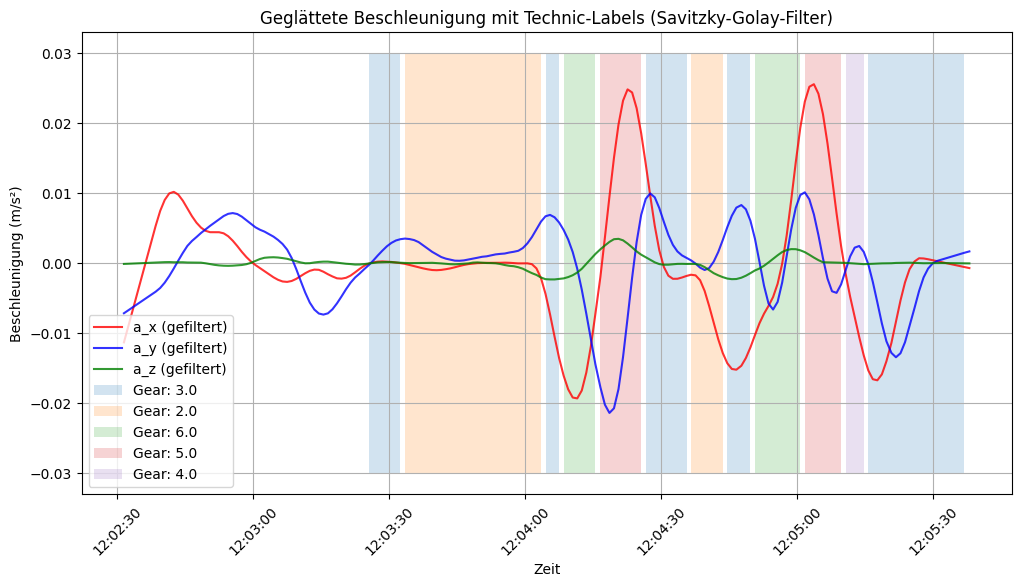

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# CSV-Datei laden
df_gears = export_data_transformed

# Nur die Daten für "nadine_faehndrich_run_1" filtern
df_filtered = df_gears[df_gears["name_run"] == "FAEHNDRICH Nadine Run__1"]

# Zeitachse erstellen
time_series = pd.to_datetime(df_filtered["time"], format="%H:%M:%S.%f")  # Zeit in DateTime-Format umwandeln

# Gefilterte Beschleunigungen
acc_x = df_filtered["ax_sp"]
acc_y = df_filtered["ay_sp"]
acc_z = df_filtered["az_sp"]

# Technic-Kategorie (Gear) abrufen und auf numerische Werte mappen
unique_technic = df_filtered["technic"].dropna().unique()  # NaN-Werte ignorieren
technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
technic_values = df_filtered["technic"].map(technic_mapping)

# Reduziere die Anzahl der Zeitstempel für bessere Performance
time_series_sampled = time_series.iloc[::10]  # Jeden 10. Wert nehmen
acc_x_sampled = acc_x.iloc[::10]
acc_y_sampled = acc_y.iloc[::10]
acc_z_sampled = acc_z.iloc[::10]
technic_values_sampled = technic_values.iloc[::10]

# Grafik erstellen
plt.figure(figsize=(12, 6))
plt.plot(time_series_sampled, acc_x_sampled, label="a_x (gefiltert)", alpha=0.8, color="red")
plt.plot(time_series_sampled, acc_y_sampled, label="a_y (gefiltert)", alpha=0.8, color="blue")
plt.plot(time_series_sampled, acc_z_sampled, label="a_z (gefiltert)", alpha=0.8, color="green")

# Gears als Hintergrundfarben markieren
for label, idx in technic_mapping.items():
    mask = technic_values_sampled == idx
    plt.fill_between(time_series_sampled, -0.03, 0.03, where=mask, alpha=0.2, label=f"Gear: {label}")

plt.xlabel("Zeit")
plt.ylabel("Beschleunigung (m/s²)")
plt.title("Geglättete Beschleunigung mit Technic-Labels (Savitzky-Golay-Filter)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Gänge in df_modified einfügen

In [ ]:
df_modified["technic"] = df_modified["time"].map(df_filtered.set_index("time")["technic"])
df_modified["technic"].unique()

array([nan,  3.,  2.,  6.,  5.,  4.])

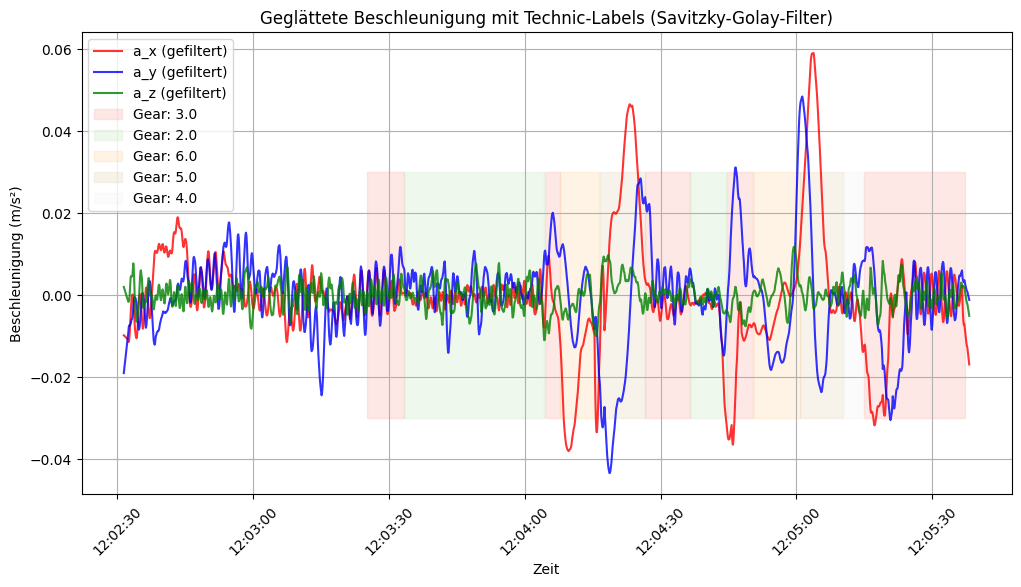

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sicherstellen, dass df_modified die "technic"-Spalte enthält
if "technic" not in df_modified.columns:
    raise ValueError("Die Spalte 'technic' fehlt in df_modified! Stelle sicher, dass sie korrekt hinzugefügt wurde.")

# Zeitachse erstellen
time_series = pd.to_datetime(df_modified["time"], format="%H:%M:%S.%f")  # Zeit in datetime umwandeln

# Gefilterte Beschleunigungen aus df_modified
acc_x = df_modified["a_x_norm_sp"]
acc_y = df_modified["a_y_norm_sp"]
acc_z = df_modified["a_elevation_sp"]



# Technic-Kategorie (Gear) auf numerische Werte mappen
unique_technic = df_modified["technic"].dropna().unique()
technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
technic_values = df_modified["technic"].map(technic_mapping)

# Farben für die verschiedenen Gears definieren
colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))  # Weiche Farben für Hintergrund

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(time_series, acc_x, label="a_x (gefiltert)", alpha=0.8, color="red")
plt.plot(time_series, acc_y, label="a_y (gefiltert)", alpha=0.8, color="blue")
plt.plot(time_series, acc_z, label="a_z (gefiltert)", alpha=0.8, color="green")

# Gears als Hintergrundfarben markieren
for idx, (label, color) in enumerate(zip(technic_mapping.keys(), colors)):
    mask = technic_values == idx
    plt.fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Gear: {label}")

plt.xlabel("Zeit")
plt.ylabel("Beschleunigung (m/s²)")
plt.title("Geglättete Beschleunigung mit Technic-Labels (Savitzky-Golay-Filter)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Strecke plotten (x, y)

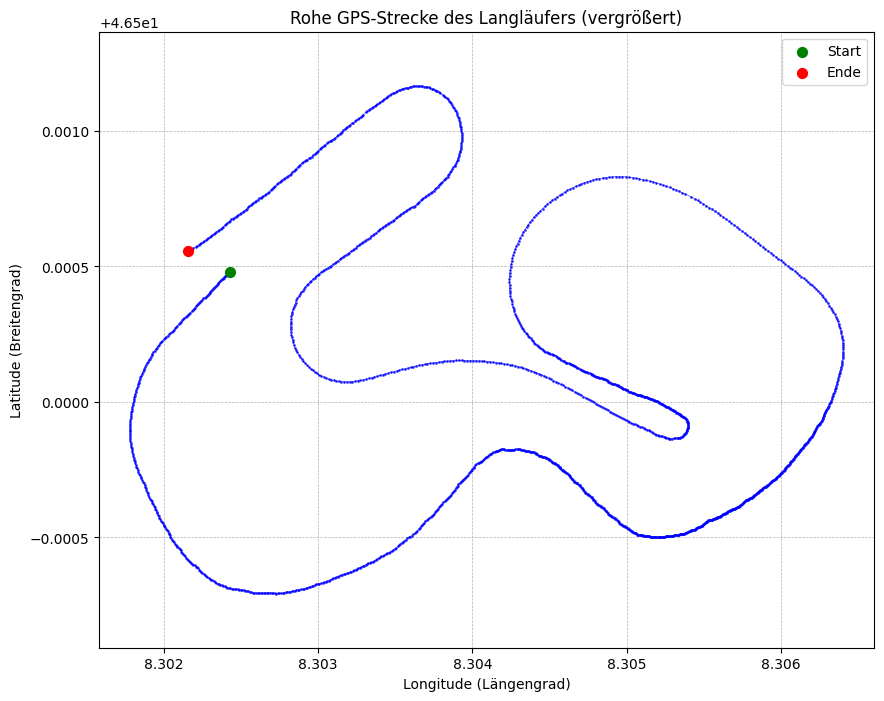

In [ ]:
import matplotlib.pyplot as plt

# GPS-Koordinaten aus dem DataFrame extrahieren
latitude = df_modified["latitude"]
longitude = df_modified["longitude"]

# Plot erstellen
plt.figure(figsize=(10, 8))  # Größere Darstellung für bessere Details
plt.plot(longitude, latitude, color="blue", marker="o", linestyle="-", markersize=1, alpha=0.7, linewidth=0.5)

# Start- und Endpunkt markieren
plt.scatter(longitude.iloc[0], latitude.iloc[0], color="green", label="Start", zorder=3, s=50)
plt.scatter(longitude.iloc[-1], latitude.iloc[-1], color="red", label="Ende", zorder=3, s=50)

# Achsenbeschriftung & Titel
plt.xlabel("Longitude (Längengrad)")
plt.ylabel("Latitude (Breitengrad)")
plt.title("Rohe GPS-Strecke des Langläufers (vergrößert)")

# Achsenbereich vergrößern, um Details sichtbar zu machen
plt.xlim(longitude.min() - 0.0002, longitude.max() + 0.0002)
plt.ylim(latitude.min() - 0.0002, latitude.max() + 0.0002)

plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)  # Dünnere Gitterlinien für bessere Übersicht

# Plot anzeigen
plt.show()

## bei strecke Innerbody entfernen (mit Savitzky_Golay rausfiltern)

In [ ]:
df_modified_Stan = df_modified.copy()
df_modified_Stan

,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v,technic
0,46.500480,8.302427,1351.381,10.3,20240127T120231400000,XC,11783,12:02:31.4,2024-01-27,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 12:02:31.400,2024-01-27 12:02:31.400,0.0,0.000000,NaN
1,46.500479,8.302423,1351.472,13.3,20240127T120231500000,XC,11783,12:02:31.5,2024-01-27,-0.369094,...,0.000000,46.500480,8.302427,0.379037,0.378899,2024-01-27 12:02:31.500,2024-01-27 12:02:31.400,0.1,3.788987,NaN
2,46.500477,8.302418,1351.411,13.7,20240127T120231600000,XC,11783,12:02:31.6,2024-01-27,-0.708476,...,-0.085640,46.500479,8.302423,0.392572,0.392429,2024-01-27 12:02:31.600,2024-01-27 12:02:31.500,0.1,3.924287,NaN
3,46.500475,8.302414,1351.401,13.7,20240127T120231700000,XC,11783,12:02:31.7,2024-01-27,-1.017755,...,-0.282667,46.500477,8.302418,0.406760,0.406611,2024-01-27 12:02:31.700,2024-01-27 12:02:31.600,0.1,4.066112,NaN
4,46.500472,8.302410,1351.482,14.6,20240127T120231800000,XC,11783,12:02:31.8,2024-01-27,-1.335394,...,-0.546636,46.500475,8.302414,0.466690,0.466520,2024-01-27 12:02:31.800,2024-01-27 12:02:31.700,0.1,4.665201,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,46.500567,8.302191,1353.517,27.0,20240127T120537800000,XC,11783,12:05:37.8,2024-01-27,-18.030371,...,10.570932,46.500574,8.302209,1.513311,1.512759,2024-01-27 12:05:37.800,2024-01-27 12:05:37.600,0.2,7.563793,NaN
1865,46.500564,8.302183,1353.531,27.0,20240127T120537900000,XC,11783,12:05:37.9,2024-01-27,-18.700775,...,9.871584,46.500567,8.302191,0.741562,0.741292,2024-01-27 12:05:37.900,2024-01-27 12:05:37.800,0.1,7.412916,NaN
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783,12:05:38.0,2024-01-27,-19.363507,...,9.555245,46.500564,8.302183,0.734657,0.734389,2024-01-27 12:05:38.000,2024-01-27 12:05:37.900,0.1,7.343888,NaN
1867,46.500559,8.302166,1353.513,25.9,20240127T120538100000,XC,11783,12:05:38.1,2024-01-27,-20.002827,...,9.238838,46.500561,8.302174,0.695094,0.694840,2024-01-27 12:05:38.100,2024-01-27 12:05:38.000,0.1,6.948404,NaN


## Kurvenbewegung smoothen

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Kopie des DataFrames für Standardisierung
df_modified_Stan = df_modified.copy()

# Savitzky-Golay-Filter anwenden (Fenstergröße & Ordnung anpassen)
window_size = 91  # Muss ungerade sein! (Erhöhen = stärkere Glättung)
order = 3  # Polynomgrad (3 ist meist ein guter Wert)

# Glättung auf GPS-Daten anwenden
df_modified_Stan["latitude_smooth"] = savgol_filter(df_modified_Stan["latitude"], window_size, order)
df_modified_Stan["longitude_smooth"] = savgol_filter(df_modified_Stan["longitude"], window_size, order)

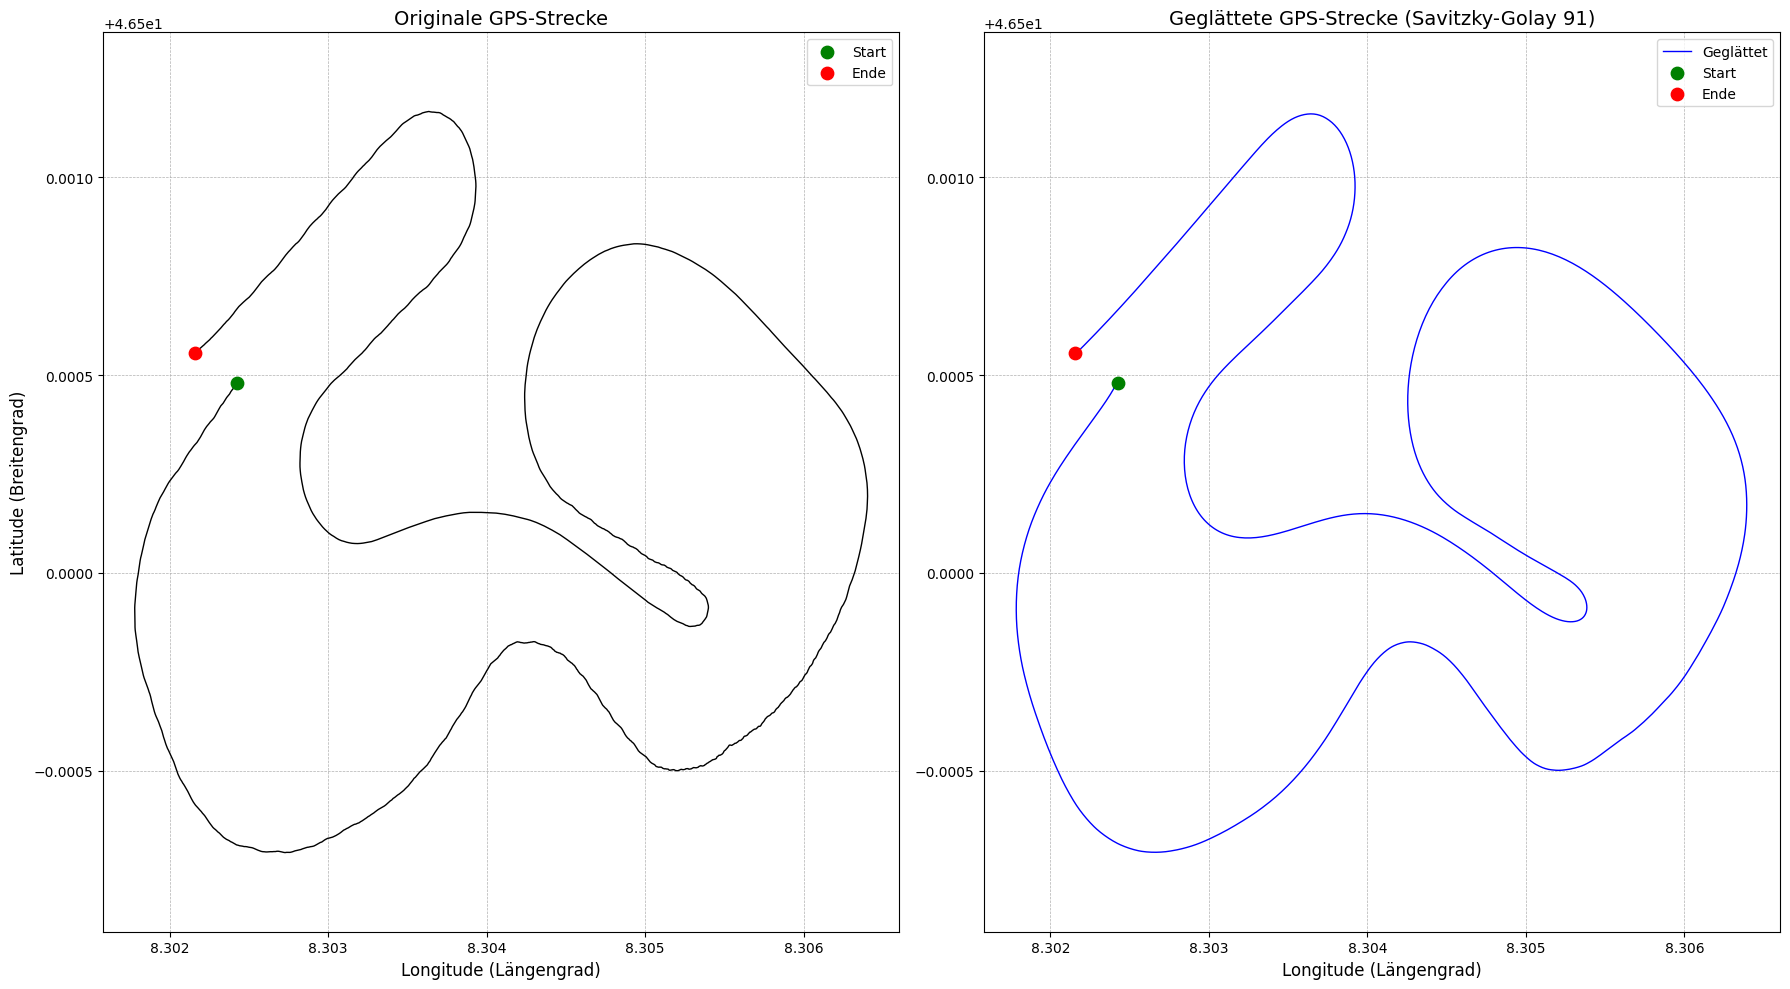

In [ ]:
# Größere Darstellung mit zwei Subplots nebeneinander
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# Original GPS-Strecke
ax[0].plot(df_modified_Stan["longitude"], df_modified_Stan["latitude"], color="black", linestyle="-", alpha=1, linewidth=1)
ax[0].scatter(df_modified_Stan["longitude"].iloc[0], df_modified_Stan["latitude"].iloc[0], color="green", label="Start", zorder=3, s=80)
ax[0].scatter(df_modified_Stan["longitude"].iloc[-1], df_modified_Stan["latitude"].iloc[-1], color="red", label="Ende", zorder=3, s=80)
ax[0].set_title("Originale GPS-Strecke", fontsize=14)
ax[0].set_xlabel("Longitude (Längengrad)", fontsize=12)
ax[0].set_ylabel("Latitude (Breitengrad)", fontsize=12)
ax[0].legend()
ax[0].grid(True, linestyle="--", linewidth=0.5)

# Geglättete GPS-Strecke
ax[1].plot(df_modified_Stan["longitude_smooth"], df_modified_Stan["latitude_smooth"], color="blue", linestyle="-", linewidth=1, label="Geglättet")
ax[1].scatter(df_modified_Stan["longitude"].iloc[0], df_modified_Stan["latitude"].iloc[0], color="green", label="Start", zorder=3, s=80)
ax[1].scatter(df_modified_Stan["longitude"].iloc[-1], df_modified_Stan["latitude"].iloc[-1], color="red", label="Ende", zorder=3, s=80)
ax[1].set_title("Geglättete GPS-Strecke (Savitzky-Golay 91)", fontsize=14)
ax[1].set_xlabel("Longitude (Längengrad)", fontsize=12)
ax[1].legend()
ax[1].grid(True, linestyle="--", linewidth=0.5)

# Gemeinsame Achsenbegrenzung für besseren Vergleich
for a in ax:
    a.set_xlim(df_modified["longitude"].min() - 0.0002, df_modified["longitude"].max() + 0.0002)
    a.set_ylim(df_modified["latitude"].min() - 0.0002, df_modified["latitude"].max() + 0.0002)

# Anzeigen der Plots
plt.tight_layout()
plt.show()


## Strecke begradigen



*   Relativwinkel bestimmen
*   diesen an nicht gefilterten anwenden
*   gerade linie sollte zwar noch innere bewegung haben, aber keine Kurven mehr
*   so sollten Kuren in Savitzky_Golay nicht mehr sichtbar sein



Glättung der Latitude/Longitude-Daten mit Savitzky-Golay.

Berechnung des Richtung Tangentenvektor für jeden punkt


Rotation der Rohdaten in ein neues Koordinatensystem, in dem die Hauptbewegung nur entlang der x-Achse stattfindet.

Plot der seitlichen Bewegung – die y-Koordinaten zeigen jetzt die
Körperbewegung nach links/rechts.


In [ ]:
print(df_modified_Stan.columns)
df_modified_Stan

Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v',
       'technic', 'latitude_smooth', 'longitude_smooth'],
      dtype='object')


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v,technic,latitude_smooth,longitude_smooth
0,46.500480,8.302427,1351.381,10.3,20240127T120231400000,XC,11783,12:02:31.4,2024-01-27,0.000000,...,NaN,0.000000,0.000000,2024-01-27 12:02:31.400,2024-01-27 12:02:31.400,0.0,0.000000,NaN,46.500484,8.302423
1,46.500479,8.302423,1351.472,13.3,20240127T120231500000,XC,11783,12:02:31.5,2024-01-27,-0.369094,...,8.302427,0.379037,0.378899,2024-01-27 12:02:31.500,2024-01-27 12:02:31.400,0.1,3.788987,NaN,46.500481,8.302420
2,46.500477,8.302418,1351.411,13.7,20240127T120231600000,XC,11783,12:02:31.6,2024-01-27,-0.708476,...,8.302423,0.392572,0.392429,2024-01-27 12:02:31.600,2024-01-27 12:02:31.500,0.1,3.924287,NaN,46.500478,8.302416
3,46.500475,8.302414,1351.401,13.7,20240127T120231700000,XC,11783,12:02:31.7,2024-01-27,-1.017755,...,8.302418,0.406760,0.406611,2024-01-27 12:02:31.700,2024-01-27 12:02:31.600,0.1,4.066112,NaN,46.500476,8.302413
4,46.500472,8.302410,1351.482,14.6,20240127T120231800000,XC,11783,12:02:31.8,2024-01-27,-1.335394,...,8.302414,0.466690,0.466520,2024-01-27 12:02:31.800,2024-01-27 12:02:31.700,0.1,4.665201,NaN,46.500473,8.302409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,46.500567,8.302191,1353.517,27.0,20240127T120537800000,XC,11783,12:05:37.8,2024-01-27,-18.030371,...,8.302209,1.513311,1.512759,2024-01-27 12:05:37.800,2024-01-27 12:05:37.600,0.2,7.563793,NaN,46.500568,8.302196
1865,46.500564,8.302183,1353.531,27.0,20240127T120537900000,XC,11783,12:05:37.9,2024-01-27,-18.700775,...,8.302191,0.741562,0.741292,2024-01-27 12:05:37.900,2024-01-27 12:05:37.800,0.1,7.412916,NaN,46.500565,8.302186
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783,12:05:38.0,2024-01-27,-19.363507,...,8.302183,0.734657,0.734389,2024-01-27 12:05:38.000,2024-01-27 12:05:37.900,0.1,7.343888,NaN,46.500561,8.302177
1867,46.500559,8.302166,1353.513,25.9,20240127T120538100000,XC,11783,12:05:38.1,2024-01-27,-20.002827,...,8.302174,0.695094,0.694840,2024-01-27 12:05:38.100,2024-01-27 12:05:38.000,0.1,6.948404,NaN,46.500557,8.302168


In [ ]:
# Tangentenvektoren für jede Position berechnen
dx = np.diff(df_modified_Stan['longitude_smooth'])
dy = np.diff(df_modified_Stan['latitude_smooth'])
phi = np.arctan2(dy, dx)  # Lokaler Winkel für jede Position (Bogenmaß)

#  Ergänze phi für die letzte Zeile, damit die Dimensionen stimmen
phi = np.append(phi, phi[-1])

# Speichere phi als neue Spalte im DataFrame
df_modified_Stan['phi_tangent'] = phi

# Falls du die Winkel in Grad statt in Bogenmaß willst:
df_modified_Stan['phi_tangent_deg'] = np.degrees(phi)  # Umwandlung in Grad

print(df_modified_Stan.columns)
df_modified_Stan

Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v',
       'technic', 'latitude_smooth', 'longitude_smooth', 'phi_tangent',
       'phi_tangent_deg'],
      dtype='object')


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,distance_x_y,date_time,shifted_date_time,time_delta,v,technic,latitude_smooth,longitude_smooth,phi_tangent,phi_tangent_deg
0,46.500480,8.302427,1351.381,10.3,20240127T120231400000,XC,11783,12:02:31.4,2024-01-27,0.000000,...,0.000000,2024-01-27 12:02:31.400,2024-01-27 12:02:31.400,0.0,0.000000,NaN,46.500484,8.302423,-2.432164,-139.352727
1,46.500479,8.302423,1351.472,13.3,20240127T120231500000,XC,11783,12:02:31.5,2024-01-27,-0.369094,...,0.378899,2024-01-27 12:02:31.500,2024-01-27 12:02:31.400,0.1,3.788987,NaN,46.500481,8.302420,-2.451145,-140.440257
2,46.500477,8.302418,1351.411,13.7,20240127T120231600000,XC,11783,12:02:31.6,2024-01-27,-0.708476,...,0.392429,2024-01-27 12:02:31.600,2024-01-27 12:02:31.500,0.1,3.924287,NaN,46.500478,8.302416,-2.468520,-141.435791
3,46.500475,8.302414,1351.401,13.7,20240127T120231700000,XC,11783,12:02:31.7,2024-01-27,-1.017755,...,0.406611,2024-01-27 12:02:31.700,2024-01-27 12:02:31.600,0.1,4.066112,NaN,46.500476,8.302413,-2.484443,-142.348119
4,46.500472,8.302410,1351.482,14.6,20240127T120231800000,XC,11783,12:02:31.8,2024-01-27,-1.335394,...,0.466520,2024-01-27 12:02:31.800,2024-01-27 12:02:31.700,0.1,4.665201,NaN,46.500473,8.302409,-2.499050,-143.185025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,46.500567,8.302191,1353.517,27.0,20240127T120537800000,XC,11783,12:05:37.8,2024-01-27,-18.030371,...,1.512759,2024-01-27 12:05:37.800,2024-01-27 12:05:37.600,0.2,7.563793,NaN,46.500568,8.302196,-2.759205,-158.090810
1865,46.500564,8.302183,1353.531,27.0,20240127T120537900000,XC,11783,12:05:37.9,2024-01-27,-18.700775,...,0.741292,2024-01-27 12:05:37.900,2024-01-27 12:05:37.800,0.1,7.412916,NaN,46.500565,8.302186,-2.760432,-158.161128
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783,12:05:38.0,2024-01-27,-19.363507,...,0.734389,2024-01-27 12:05:38.000,2024-01-27 12:05:37.900,0.1,7.343888,NaN,46.500561,8.302177,-2.761672,-158.232139
1867,46.500559,8.302166,1353.513,25.9,20240127T120538100000,XC,11783,12:05:38.1,2024-01-27,-20.002827,...,0.694840,2024-01-27 12:05:38.100,2024-01-27 12:05:38.000,0.1,6.948404,NaN,46.500557,8.302168,-2.762923,-158.303839


In [ ]:
df_modified_Stan.columns

Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v',
       'technic', 'latitude_smooth', 'longitude_smooth', 'phi_tangent',
       'phi_tangent_deg'],
      dtype='object')

In [ ]:
df_modified_Stan['phi_tangent'].min()

-3.141561342116512

In [ ]:
df_modified_Stan['phi_tangent'].max()

3.135126873826535

## Neu Winkel Phi an Ableitungen setzen



*   df_modified["a_x_norm_sp"]
*   df_modified["a_y_norm_sp"]

*   



In [ ]:
df_modified_Stan_ab = df_modified_Stan.copy()
df_modified_Stan_ab

,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,distance_x_y,date_time,shifted_date_time,time_delta,v,technic,latitude_smooth,longitude_smooth,phi_tangent,phi_tangent_deg
0,46.500480,8.302427,1351.381,10.3,20240127T120231400000,XC,11783,12:02:31.4,2024-01-27,0.000000,...,0.000000,2024-01-27 12:02:31.400,2024-01-27 12:02:31.400,0.0,0.000000,NaN,46.500484,8.302423,-2.432164,-139.352727
1,46.500479,8.302423,1351.472,13.3,20240127T120231500000,XC,11783,12:02:31.5,2024-01-27,-0.369094,...,0.378899,2024-01-27 12:02:31.500,2024-01-27 12:02:31.400,0.1,3.788987,NaN,46.500481,8.302420,-2.451145,-140.440257
2,46.500477,8.302418,1351.411,13.7,20240127T120231600000,XC,11783,12:02:31.6,2024-01-27,-0.708476,...,0.392429,2024-01-27 12:02:31.600,2024-01-27 12:02:31.500,0.1,3.924287,NaN,46.500478,8.302416,-2.468520,-141.435791
3,46.500475,8.302414,1351.401,13.7,20240127T120231700000,XC,11783,12:02:31.7,2024-01-27,-1.017755,...,0.406611,2024-01-27 12:02:31.700,2024-01-27 12:02:31.600,0.1,4.066112,NaN,46.500476,8.302413,-2.484443,-142.348119
4,46.500472,8.302410,1351.482,14.6,20240127T120231800000,XC,11783,12:02:31.8,2024-01-27,-1.335394,...,0.466520,2024-01-27 12:02:31.800,2024-01-27 12:02:31.700,0.1,4.665201,NaN,46.500473,8.302409,-2.499050,-143.185025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,46.500567,8.302191,1353.517,27.0,20240127T120537800000,XC,11783,12:05:37.8,2024-01-27,-18.030371,...,1.512759,2024-01-27 12:05:37.800,2024-01-27 12:05:37.600,0.2,7.563793,NaN,46.500568,8.302196,-2.759205,-158.090810
1865,46.500564,8.302183,1353.531,27.0,20240127T120537900000,XC,11783,12:05:37.9,2024-01-27,-18.700775,...,0.741292,2024-01-27 12:05:37.900,2024-01-27 12:05:37.800,0.1,7.412916,NaN,46.500565,8.302186,-2.760432,-158.161128
1866,46.500561,8.302174,1353.541,26.7,20240127T120538000000,XC,11783,12:05:38.0,2024-01-27,-19.363507,...,0.734389,2024-01-27 12:05:38.000,2024-01-27 12:05:37.900,0.1,7.343888,NaN,46.500561,8.302177,-2.761672,-158.232139
1867,46.500559,8.302166,1353.513,25.9,20240127T120538100000,XC,11783,12:05:38.1,2024-01-27,-20.002827,...,0.694840,2024-01-27 12:05:38.100,2024-01-27 12:05:38.000,0.1,6.948404,NaN,46.500557,8.302168,-2.762923,-158.303839


In [ ]:

# **1️ Umwandlung von `phi_tangent_deg` in Radiant**
df_modified_Stan_ab["phi_tangent_rad"] = np.deg2rad(df_modified_Stan_ab["phi_tangent_deg"])

# **2️⃣ Rotationsmatrix auf die Beschleunigungswerte anwenden**
def rotate_acceleration(ax, ay, phi_rad):
    """Rotiert die Beschleunigungen basierend auf dem Winkel phi_rad"""
    cos_phi = np.cos(-phi_rad)
    sin_phi = np.sin(-phi_rad)

    ax_rot = cos_phi * ax - sin_phi * ay
    ay_rot = sin_phi * ax + cos_phi * ay

    return ax_rot, ay_rot

# Transformation für jede Zeile anwenden
df_modified_Stan_ab["a_x_rot"], df_modified_Stan_ab["a_y_rot"] = zip(*df_modified_Stan_ab.apply(
    lambda row: rotate_acceleration(row["a_x_norm_sp"], row["a_y_norm_sp"], row["phi_tangent_rad"]), axis=1
))


In [ ]:
df_modified_Stan_ab[["a_x_norm_sp","a_y_norm_sp","phi_tangent_deg", "a_x_rot", "a_y_rot"]]

,a_x_norm_sp,a_y_norm_sp,phi_tangent_deg,a_x_rot,a_y_rot
0,-0.009804,-0.019032,-139.352727,0.019836,0.008054
1,-0.009915,-0.018036,-140.440257,0.019131,0.007590
2,-0.010027,-0.017040,-141.435791,0.018463,0.007073
3,-0.010138,-0.016044,-142.348119,0.017828,0.006510
4,-0.010250,-0.015048,-143.185025,0.017223,0.005905
...,...,...,...,...,...
1864,-0.012948,0.000749,-158.090810,0.011733,-0.005526
1865,-0.013942,0.000265,-158.161128,0.012843,-0.005432
1866,-0.014936,-0.000219,-158.232139,0.013953,-0.005336
1867,-0.015931,-0.000703,-158.303839,0.015062,-0.005236


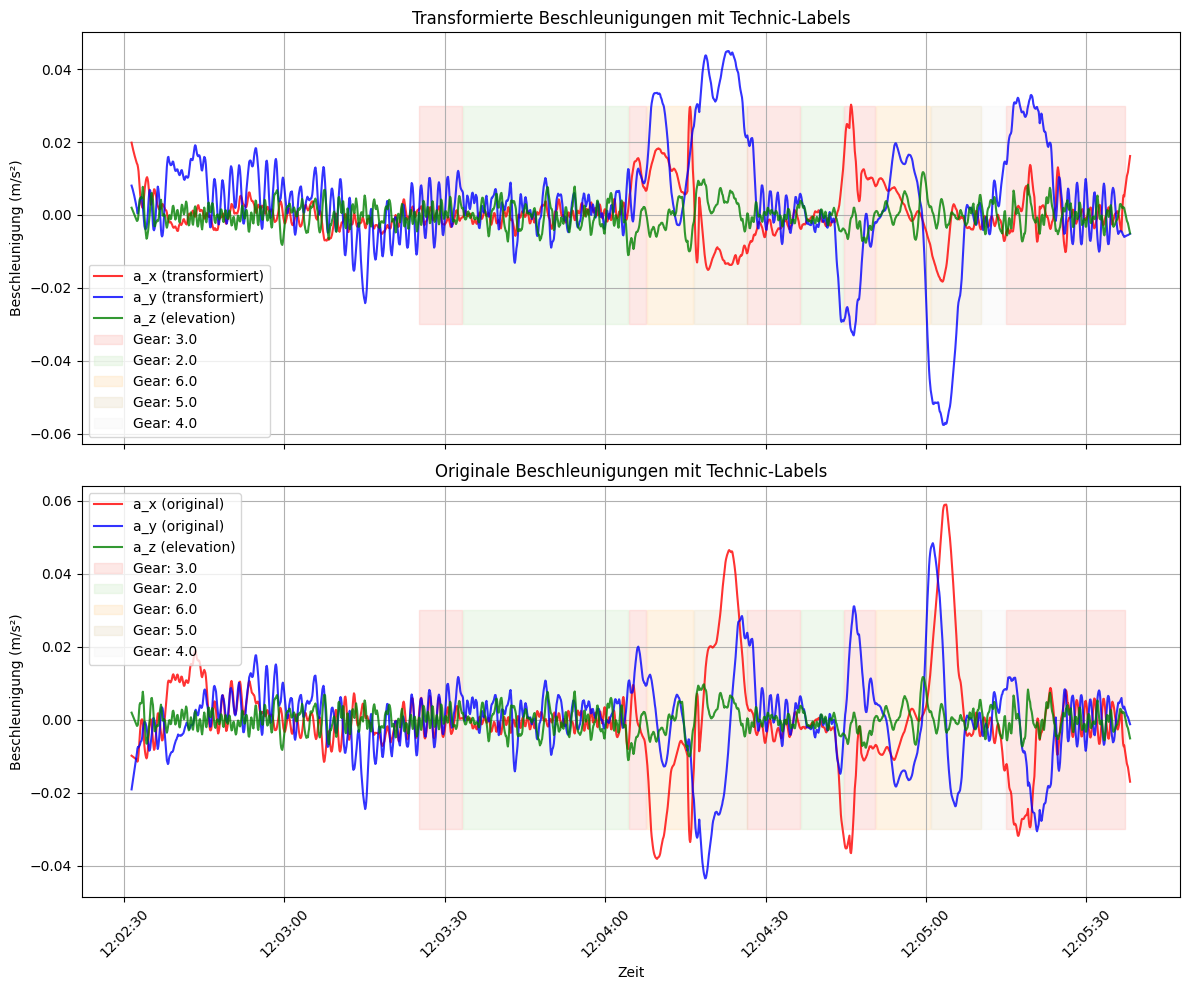

In [ ]:
# Sicherstellen, dass df_modified_Stan_ab die "technic"-Spalte enthält
if "technic" not in df_modified_Stan_ab.columns:
    raise ValueError("Die Spalte 'technic' fehlt in df_modified_Stan_ab! Stelle sicher, dass sie korrekt hinzugefügt wurde.")

# Zeitachse erstellen
time_series = pd.to_datetime(df_modified_Stan_ab["time"], format="%H:%M:%S.%f")  # Zeit in datetime umwandeln

# Gefilterte und Original-Beschleunigungen aus df_modified_Stan_ab
acc_x_rot = df_modified_Stan_ab["a_x_rot"]
acc_y_rot = df_modified_Stan_ab["a_y_rot"]
acc_z = df_modified_Stan_ab["a_elevation_sp"]

acc_x_orig = df_modified_Stan_ab["a_x_norm_sp"]
acc_y_orig = df_modified_Stan_ab["a_y_norm_sp"]

# Technic-Kategorie (Gear) auf numerische Werte mappen
unique_technic = df_modified_Stan_ab["technic"].dropna().unique()
technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
technic_values = df_modified_Stan_ab["technic"].map(technic_mapping)

# Farben für die verschiedenen Gears definieren
colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))  # Weiche Farben für Hintergrund

# Erstellen der Subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# **Plot 1: Transformierte (gefilterte) Beschleunigungen**
axes[0].plot(time_series, acc_x_rot, label="a_x (transformiert)", alpha=0.8, color="red")
axes[0].plot(time_series, acc_y_rot, label="a_y (transformiert)", alpha=0.8, color="blue")
axes[0].plot(time_series, acc_z, label="a_z (elevation)", alpha=0.8, color="green")

# Gears als Hintergrundfarben markieren
for idx, (label, color) in enumerate(zip(technic_mapping.keys(), colors)):
    mask = technic_values == idx
    axes[0].fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Gear: {label}")

axes[0].set_ylabel("Beschleunigung (m/s²)")
axes[0].set_title("Transformierte Beschleunigungen mit Technic-Labels")
axes[0].legend()
axes[0].grid(True)

# **Plot 2: Originale Beschleunigungen**
axes[1].plot(time_series, acc_x_orig, label="a_x (original)", alpha=0.8, color="red")
axes[1].plot(time_series, acc_y_orig, label="a_y (original)", alpha=0.8, color="blue")
axes[1].plot(time_series, acc_z, label="a_z (elevation)", alpha=0.8, color="green")

# Gears als Hintergrundfarben markieren
for idx, (label, color) in enumerate(zip(technic_mapping.keys(), colors)):
    mask = technic_values == idx
    axes[1].fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Gear: {label}")

axes[1].set_xlabel("Zeit")
axes[1].set_ylabel("Beschleunigung (m/s²)")
axes[1].set_title("Originale Beschleunigungen mit Technic-Labels")
axes[1].legend()
axes[1].grid(True)

# **Anzeigen der Plots**
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


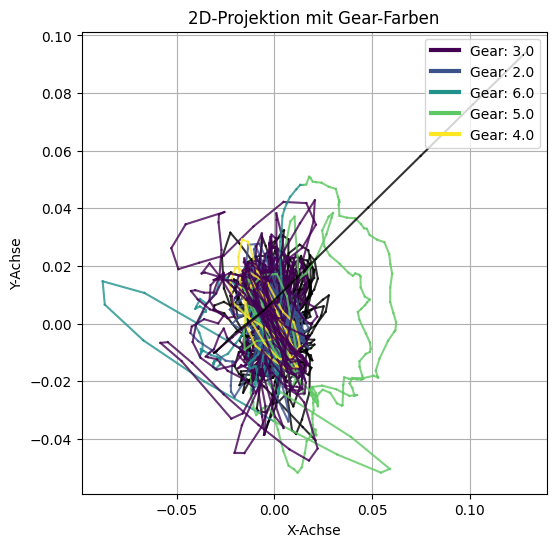

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nullpunkt setzen (die Werte sind relativ dazu)
x = df_modified["a_x_norm_sp"]
y = df_modified["a_y_norm_sp"]
technic = df_modified["technic"]  # Gear-Kategorie

# Einzigartige Gears extrahieren & Farben zuweisen
unique_technic = technic.dropna().unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))  # Viridis Farbpalette

technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

plt.figure(figsize=(6, 6))

# Farbiges Plotten je nach Gear
for i in range(len(x) - 1):
    plt.plot(x[i:i+2], y[i:i+2], color=technic_mapping.get(technic.iloc[i], "black"), alpha=0.8)

# Nullpunkt markieren
plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")

# Legende manuell erstellen**: Marker für jede Gear-Farbe hinzufügen
legend_patches = [plt.Line2D([0], [0], color=color, lw=3, label=f"Gear: {gear}")
                  for gear, color in technic_mapping.items()]

plt.legend(handles=legend_patches, loc="upper right")

# Achsen & Titel
plt.xlabel("X-Achse")
plt.ylabel("Y-Achse")
plt.title("2D-Projektion mit Gear-Farben")
plt.grid(True)
plt.show()

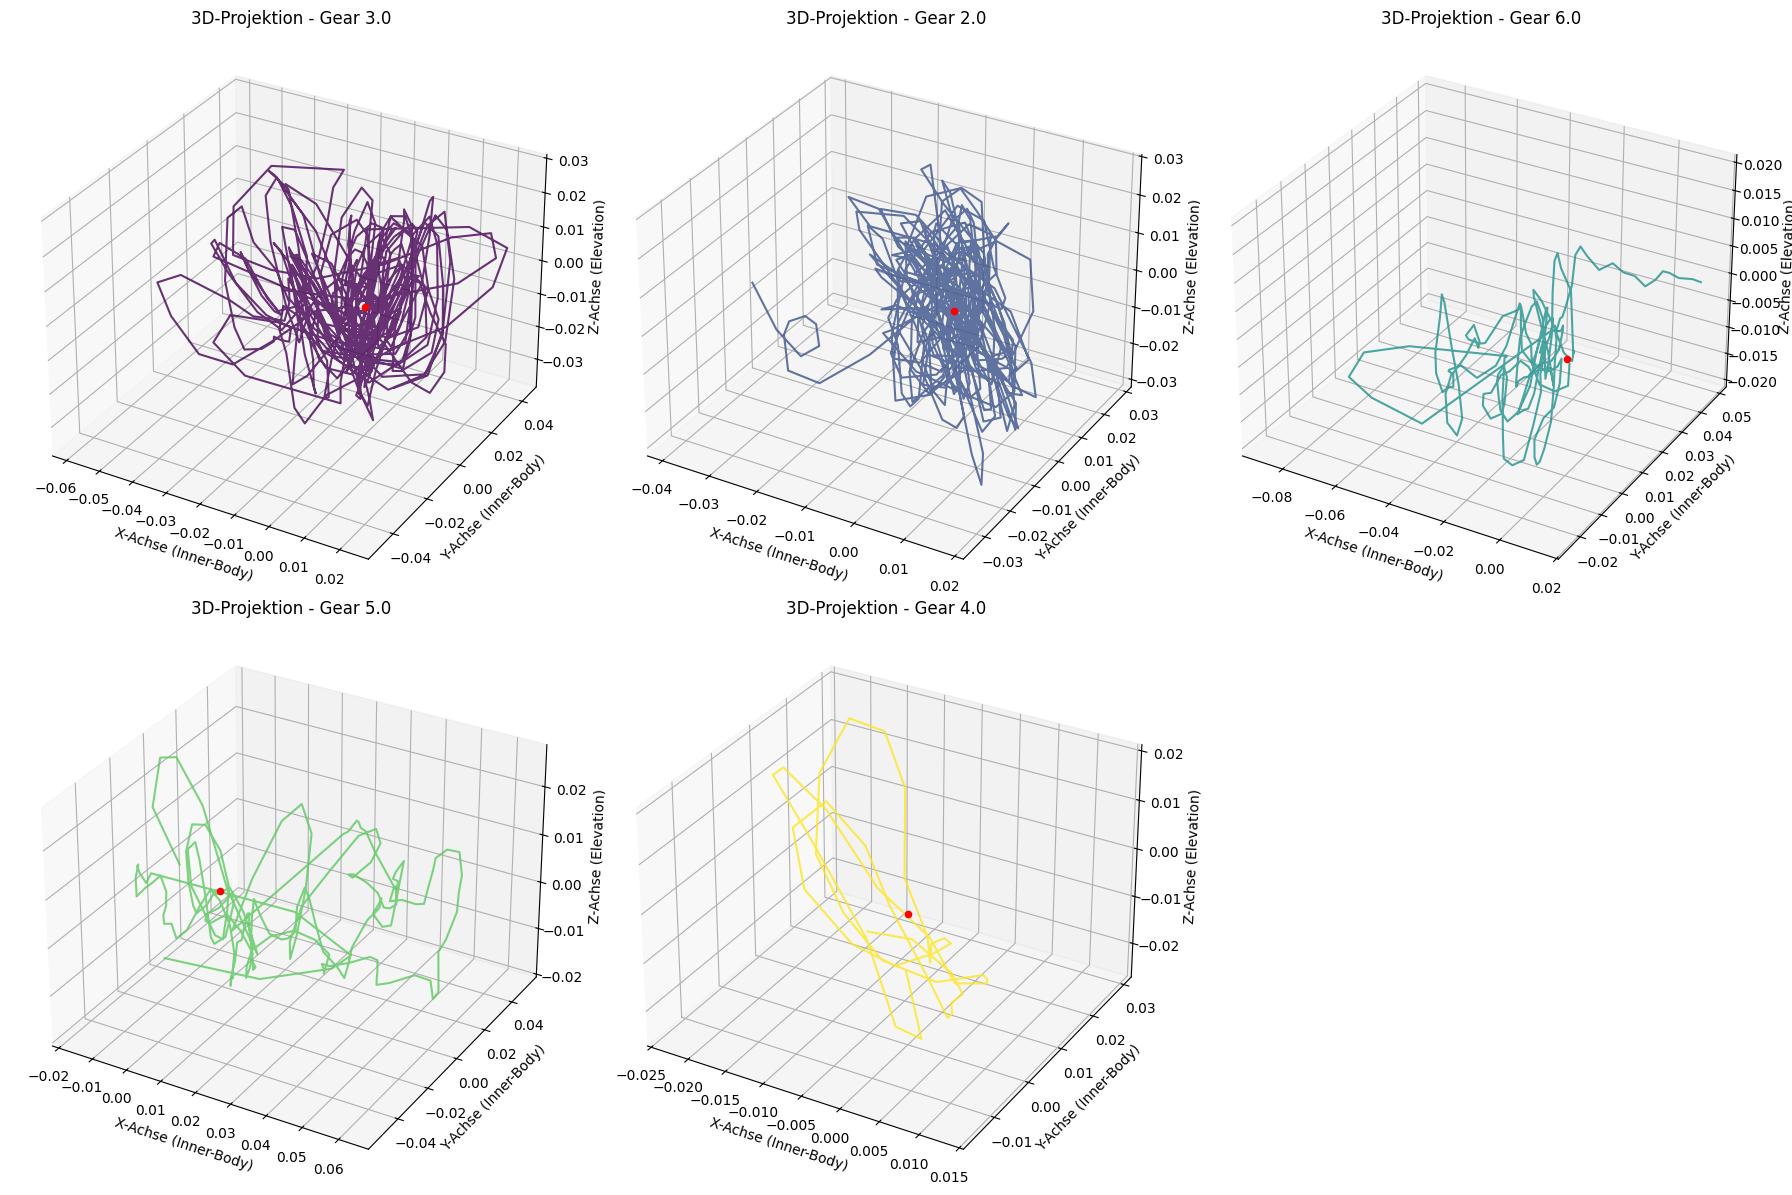

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Nullpunkt setzen (die Werte sind relativ dazu)
x = df_modified["a_x_norm_sp"]
y = df_modified["a_y_norm_sp"]
z = df_modified["a_elevation_sp"]  # Z-Achse für 3D-Darstellung
technic = df_modified["technic"]  # Gear-Kategorie

# Einzigartige Gears extrahieren & Farben zuweisen
unique_technic = technic.dropna().unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))  # Viridis Farbpalette
technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

# **Mehrere Plots erstellen - ein 3D-Plot pro Gear**
fig = plt.figure(figsize=(18, 12))  # Größere Figur für mehrere Plots

for idx, gear in enumerate(unique_technic):
    ax = fig.add_subplot(2, 3, idx + 1, projection="3d")  # 2x3 Grid für 6 Plots

    # Werte filtern für das aktuelle Gear
    mask = technic == gear
    x_filtered, y_filtered, z_filtered = x[mask], y[mask], z[mask]

    # Gear-spezifische Farbe
    color = technic_mapping.get(gear, "black")

    # 3D-Pfad plotten
    ax.plot(x_filtered, y_filtered, z_filtered, color=color, alpha=0.8)

    # Nullpunkt markieren
    ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")

    # Achsen & Titel setzen
    ax.set_xlabel("X-Achse (Inner-Body)")
    ax.set_ylabel("Y-Achse (Inner-Body)")
    ax.set_zlabel("Z-Achse (Elevation)")
    ax.set_title(f"3D-Projektion - Gear {gear}")

# Finale Darstellung
plt.tight_layout()
plt.show()


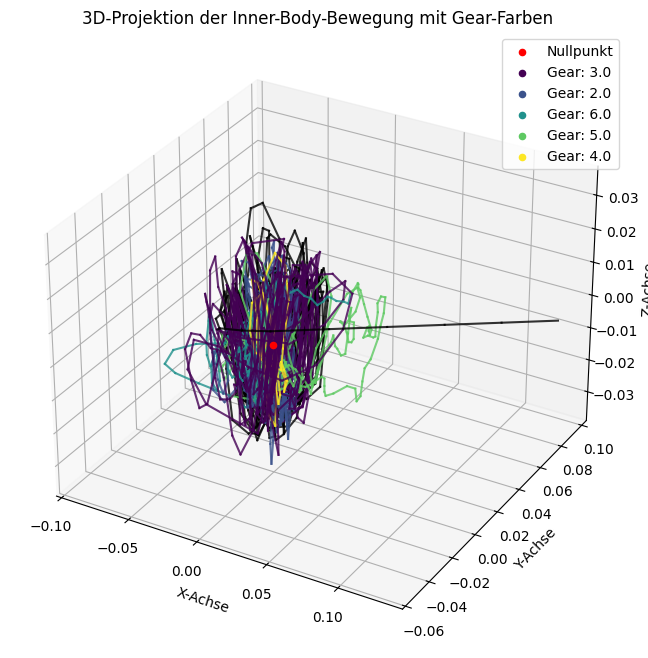

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Nullpunkt setzen (die Werte sind relativ dazu)
x = df_modified["a_x_norm_sp"]
y = df_modified["a_y_norm_sp"]
z = df_modified["a_elevation_sp"]  # Z-Achse für 3D-Darstellung
technic = df_modified["technic"]  # Gear-Kategorie

# Einzigartige Gears extrahieren & Farben zuweisen
unique_technic = technic.dropna().unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))  # Viridis Farbpalette

technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

# 3D-Figur erstellen
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Farbiges Plotten je nach Gear
for i in range(len(x) - 1):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=technic_mapping.get(technic.iloc[i], "black"), alpha=0.8)

# Nullpunkt markieren
ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")

# Legende für Gears erstellen
for gear, color in technic_mapping.items():
    ax.scatter([], [], [], color=color, label=f"Gear: {gear}")  # Leere Punkte für Legende

# Achsen & Titel
ax.set_xlabel("X-Achse")
ax.set_ylabel("Y-Achse")
ax.set_zlabel("Z-Achse")
ax.set_title("3D-Projektion der Inner-Body-Bewegung mit Gear-Farben")
ax.legend()
plt.show()

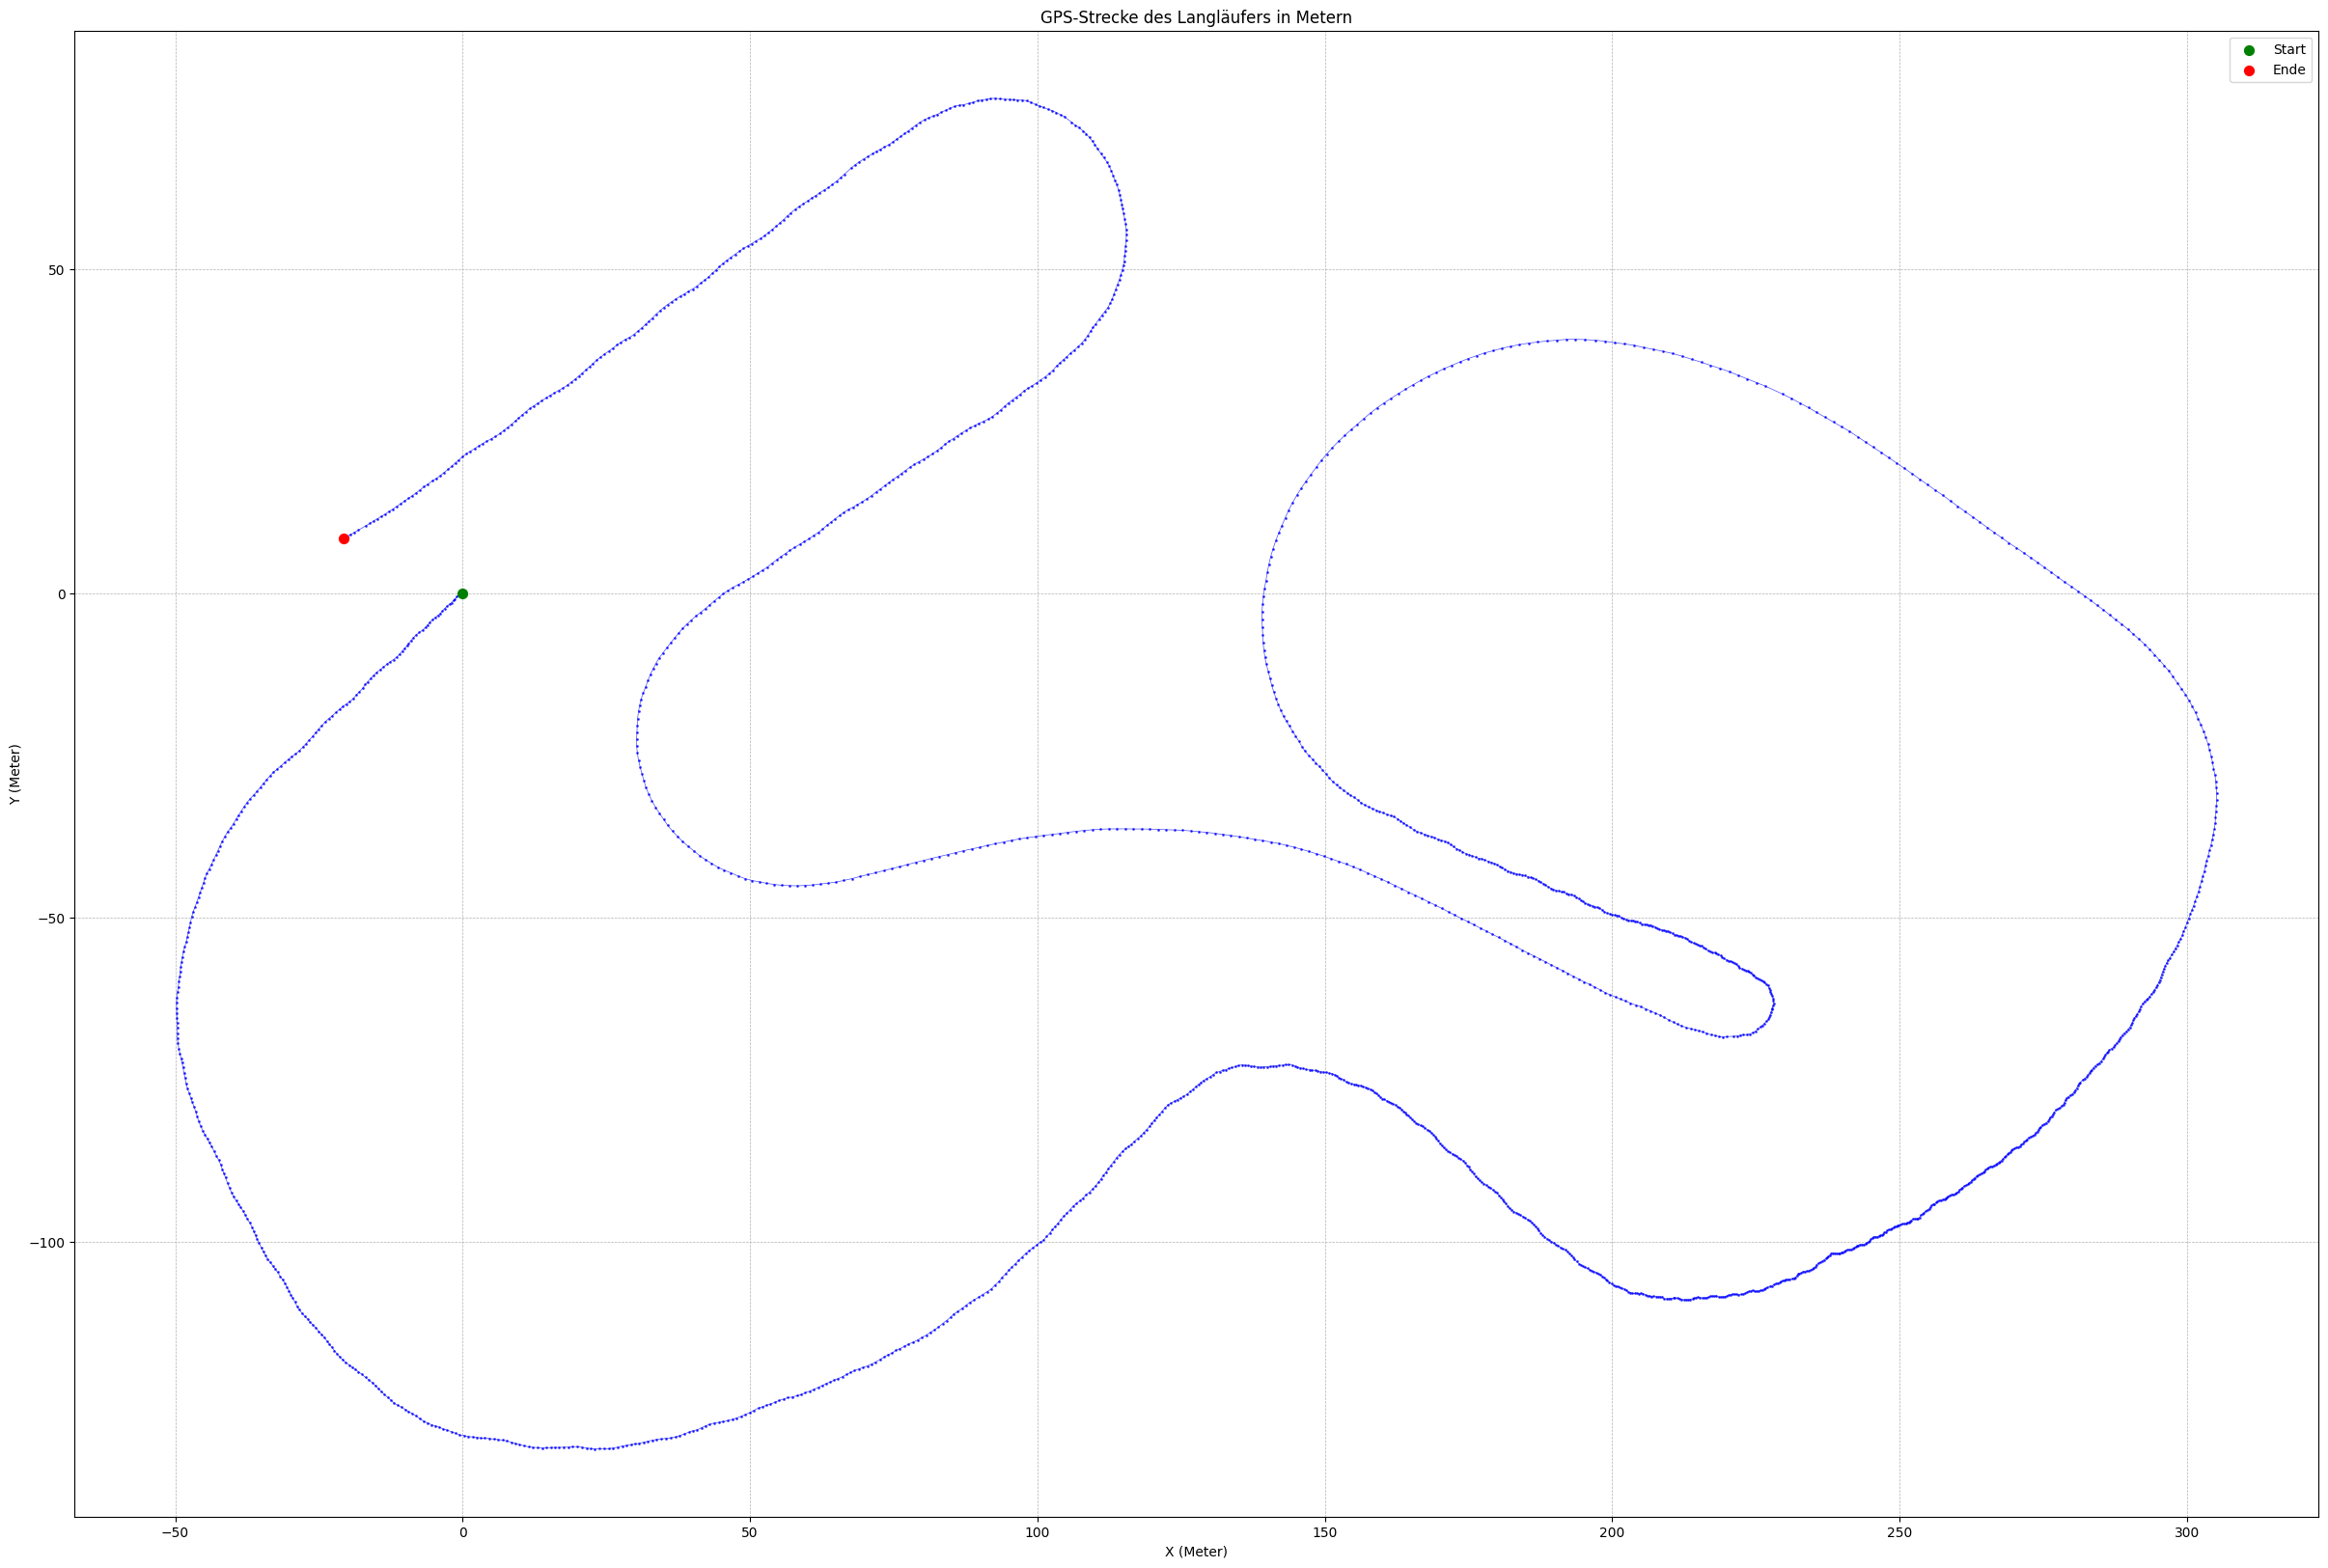

In [289]:
from geopy.distance import geodesic

# Sicherstellen, dass die Daten vorhanden sind
df_gps = df_modified.copy()

# Ursprungspunkt als Referenz (erster GPS-Punkt)
lat0, lon0 = df_gps.iloc[0]["latitude"], df_gps.iloc[0]["longitude"]

# Umwandlung der GPS-Koordinaten in lokale kartesische Meter
x_values = []
y_values = []

for _, row in df_gps.iterrows():
    lat, lon = row["latitude"], row["longitude"]

    # Abstand in Ost-West Richtung (Longitude)
    x = geodesic((lat0, lon0), (lat0, lon)).meters

    # Abstand in Nord-Süd Richtung (Latitude)
    y = geodesic((lat0, lon0), (lat, lon0)).meters

    # Falls die Längendifferenz negativ ist, machen wir x negativ
    if lon < lon0:
        x = -x

    # Falls die Breitendifferenz negativ ist, machen wir y negativ
    if lat < lat0:
        y = -y

    x_values.append(x)
    y_values.append(y)

# Neue Koordinaten im DataFrame speichern
df_gps["x_m"] = x_values
df_gps["y_m"] = y_values

# **Plot der umgerechneten Strecke in Metern**
plt.figure(figsize=(30, 20))
plt.plot(df_gps["x_m"], df_gps["y_m"], color="blue", marker="o", linestyle="-", markersize=1, alpha=0.7, linewidth=0.5)

# **Start- und Endpunkt markieren**
plt.scatter(df_gps["x_m"].iloc[0], df_gps["y_m"].iloc[0], color="green", label="Start", zorder=3, s=50)
plt.scatter(df_gps["x_m"].iloc[-1], df_gps["y_m"].iloc[-1], color="red", label="Ende", zorder=3, s=50)

# **Achsenbeschriftung & Titel**
plt.xlabel("X (Meter)")
plt.ylabel("Y (Meter)")
plt.title("GPS-Strecke des Langläufers in Metern")

plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)

# **Plot anzeigen**
plt.show()




# Testdaten erzeugen (Halbkreis mit Innerbody)



*   Ziel a_lr/a_vz
*   Lattitude / Longitude



In [411]:
# **Erstellung der Testdaten für den Schwerpunkt + Körperbewegung**

# Parameter für die Bewegung
R = 40  # Radius der Kurve in Metern
V = 20  # Geschwindigkeit in m/s
omega = V / R  # Winkelgeschwindigkeit

# Zeitvektor für eine ganze Kreisbewegung (0 bis 2π)
t = np.linspace(0, (np.pi)*2, num=500)  # 500 Punkte für eine sanfte Kurve

# **1️⃣ Schwerpunktbewegung (Schöne Kurve)**
x_sp = R * np.cos(omega * t)  # X-Koordinate des Schwerpunkts
y_sp = R * np.sin(omega * t)  # Y-Koordinate des Schwerpunkts

# **2️⃣ Berechnung des Winkels phi für jeden Punkt (Bewegungsrichtung)**
phi = omega*t

# **3️⃣ Körperbewegung mit seitlicher Abweichung (x_LR) und Vorwärtsschwankung (y_vz)**
A_xLR = 0.3  # Amplitude der seitlichen Bewegung (Links/Rechts-Kippen)
A_yVZ = 0.2  # Amplitude der Vorwärtsbewegungsschwankung
omega_inner = omega * 2  # Höhere Frequenz der inneren Bewegung

x_LR = A_xLR * np.sin(omega_inner * t)  # Seitliche Kippbewegung
y_vz = A_yVZ * np.sin(omega_inner * t)  # Vorwärtsbewegungsschwankung

# **4️⃣ Berechnung der Körperbewegung aus deiner Formel**
x = x_sp + x_LR * np.cos(phi) - y_vz * np.sin(phi)
y = y_sp + x_LR * np.sin(phi) + y_vz * np.cos(phi)

# **5️⃣ Erstellung des DataFrame mit Schwerpunkt- & Körperbewegung**
df_testdata_MB = pd.DataFrame({
    "t": t,
    "x_sp": x_sp,
    "y_sp": y_sp,
    "x": x,  # Endgültige Körperposition mit Schwankung
    "y": y,
    "phi": phi,  # Bewegungswinkel
    "x_LR": x_LR,  # Seitliche Bewegung
    "y_vz": y_vz,  # Vorwärtsschwankung
    "streckenlänge": np.pi * R  # Länge des gesamten Kreises
})





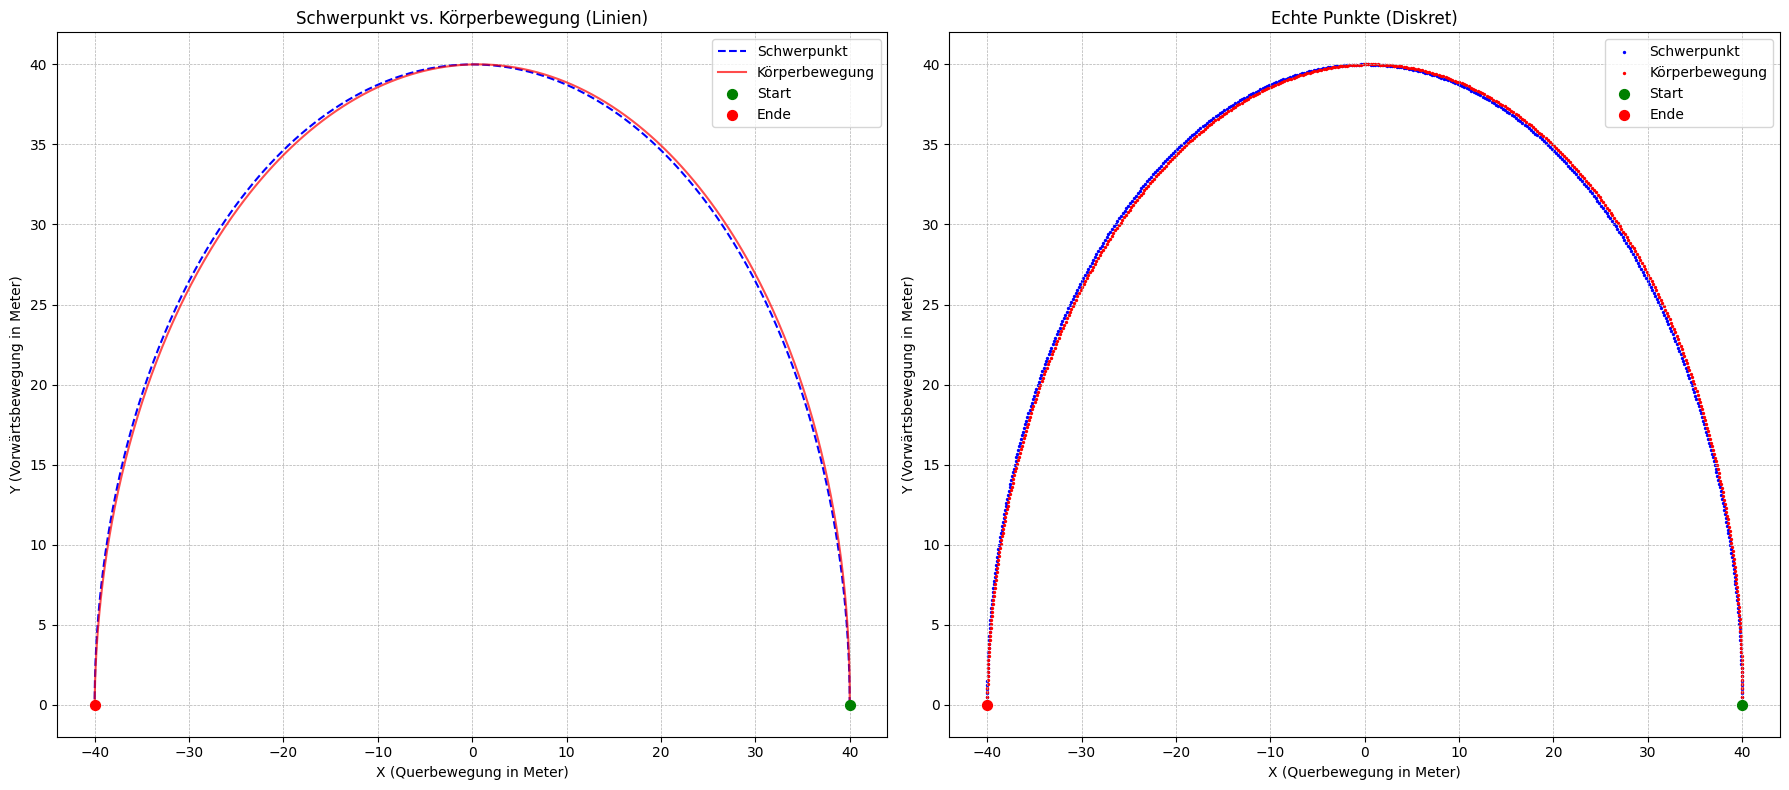

In [412]:
# **Visualisierung der Bewegung mit zwei Plots nebeneinander:**
# 1️⃣ Links: Vollständige Linien für Schwerpunkt & Körperbewegung
# 2️⃣ Rechts: Nur die echten Punkte (diskrete Datenpunkte)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# **Plot 1: Schwerpunkt & Körperbewegung (Linien)**
axes[0].plot(df_testdata_MB["x_sp"], df_testdata_MB["y_sp"], color="blue", linestyle="--", label="Schwerpunkt")
axes[0].plot(df_testdata_MB["x"], df_testdata_MB["y"], color="red", linestyle="-", alpha=0.7, label="Körperbewegung")

# **Start- und Endpunkt markieren**
axes[0].scatter(df_testdata_MB["x_sp"].iloc[0], df_testdata_MB["y_sp"].iloc[0], color="green", label="Start", zorder=3, s=50)
axes[0].scatter(df_testdata_MB["x_sp"].iloc[-1], df_testdata_MB["y_sp"].iloc[-1], color="red", label="Ende", zorder=3, s=50)

axes[0].set_xlabel("X (Querbewegung in Meter)")
axes[0].set_ylabel("Y (Vorwärtsbewegung in Meter)")
axes[0].set_title("Schwerpunkt vs. Körperbewegung (Linien)")
axes[0].legend()
axes[0].grid(True, linestyle="--", linewidth=0.5)

# **Plot 2: Echte Punkte ohne Verbindungslinien**
axes[1].scatter(df_testdata_MB["x_sp"], df_testdata_MB["y_sp"], color="blue", label="Schwerpunkt", s=2)
axes[1].scatter(df_testdata_MB["x"], df_testdata_MB["y"], color="red", label="Körperbewegung", s=2)

# **Start- und Endpunkt markieren**
axes[1].scatter(df_testdata_MB["x_sp"].iloc[0], df_testdata_MB["y_sp"].iloc[0], color="green", label="Start", zorder=3, s=50)
axes[1].scatter(df_testdata_MB["x_sp"].iloc[-1], df_testdata_MB["y_sp"].iloc[-1], color="red", label="Ende", zorder=3, s=50)

axes[1].set_xlabel("X (Querbewegung in Meter)")
axes[1].set_ylabel("Y (Vorwärtsbewegung in Meter)")
axes[1].set_title("Echte Punkte (Diskret)")
axes[1].legend()
axes[1].grid(True, linestyle="--", linewidth=0.5)

# **Plots anzeigen**
plt.tight_layout()
plt.show()



## Mehr Perioden

In [413]:
# **Erstellung der Testdaten für den Schwerpunkt + Körperbewegung mit mehr Amplitude & Perioden**

# Parameter für die Bewegung
R = 40  # Radius der Kurve in Metern
V = 20  # Geschwindigkeit in m/s
omega = V / R  # Winkelgeschwindigkeit

# Zeitvektor für eine ganze Kreisbewegung (0 bis 2π)
t = np.linspace(0, (np.pi) * 2, num=500)  # 500 Punkte für eine sanfte Kurve

# **1️⃣ Schwerpunktbewegung (Schöne Kurve)**
x_sp = R * np.cos(omega * t)  # X-Koordinate des Schwerpunkts
y_sp = R * np.sin(omega * t)  # Y-Koordinate des Schwerpunkts

# **2️⃣ Berechnung des Winkels phi für jeden Punkt (Bewegungsrichtung)**
phi = omega * t

# **3️⃣ Körperbewegung mit stärkerer Abweichung (x_LR) und mehr Vorwärtsschwankung (y_vz)**
A_xLR = 0.8  # Erhöhte Amplitude der seitlichen Bewegung (Links/Rechts-Kippen)
A_yVZ = 1.0  # Erhöhte Amplitude der Vorwärtsbewegungsschwankung
omega_inner = omega * 24  # Höhere Frequenz der inneren Bewegung (Mehr Perioden)

x_LR = A_xLR * np.sin(omega_inner * t)  # Seitliche Kippbewegung
y_vz = A_yVZ * np.sin(omega_inner * t)  # Vorwärtsbewegungsschwankung

# **4️⃣ Berechnung der Körperbewegung aus der Formel**
x = x_sp + x_LR * np.cos(phi) - y_vz * np.sin(phi)
y = y_sp + x_LR * np.sin(phi) + y_vz * np.cos(phi)

# **5️⃣ Erstellung des DataFrame mit Schwerpunkt- & Körperbewegung**
df_testdata_LOF = pd.DataFrame({
    "t": t,
    "x_sp": x_sp,
    "y_sp": y_sp,
    "x": x,  # Endgültige Körperposition mit stärkerer Schwankung
    "y": y,
    "phi": phi,  # Bewegungswinkel
    "x_LR": x_LR,  # Verstärkte Seitliche Bewegung
    "y_vz": y_vz,  # Verstärkte Vorwärtsschwankung
    "streckenlänge": np.pi * R  # Länge des gesamten Kreises
})


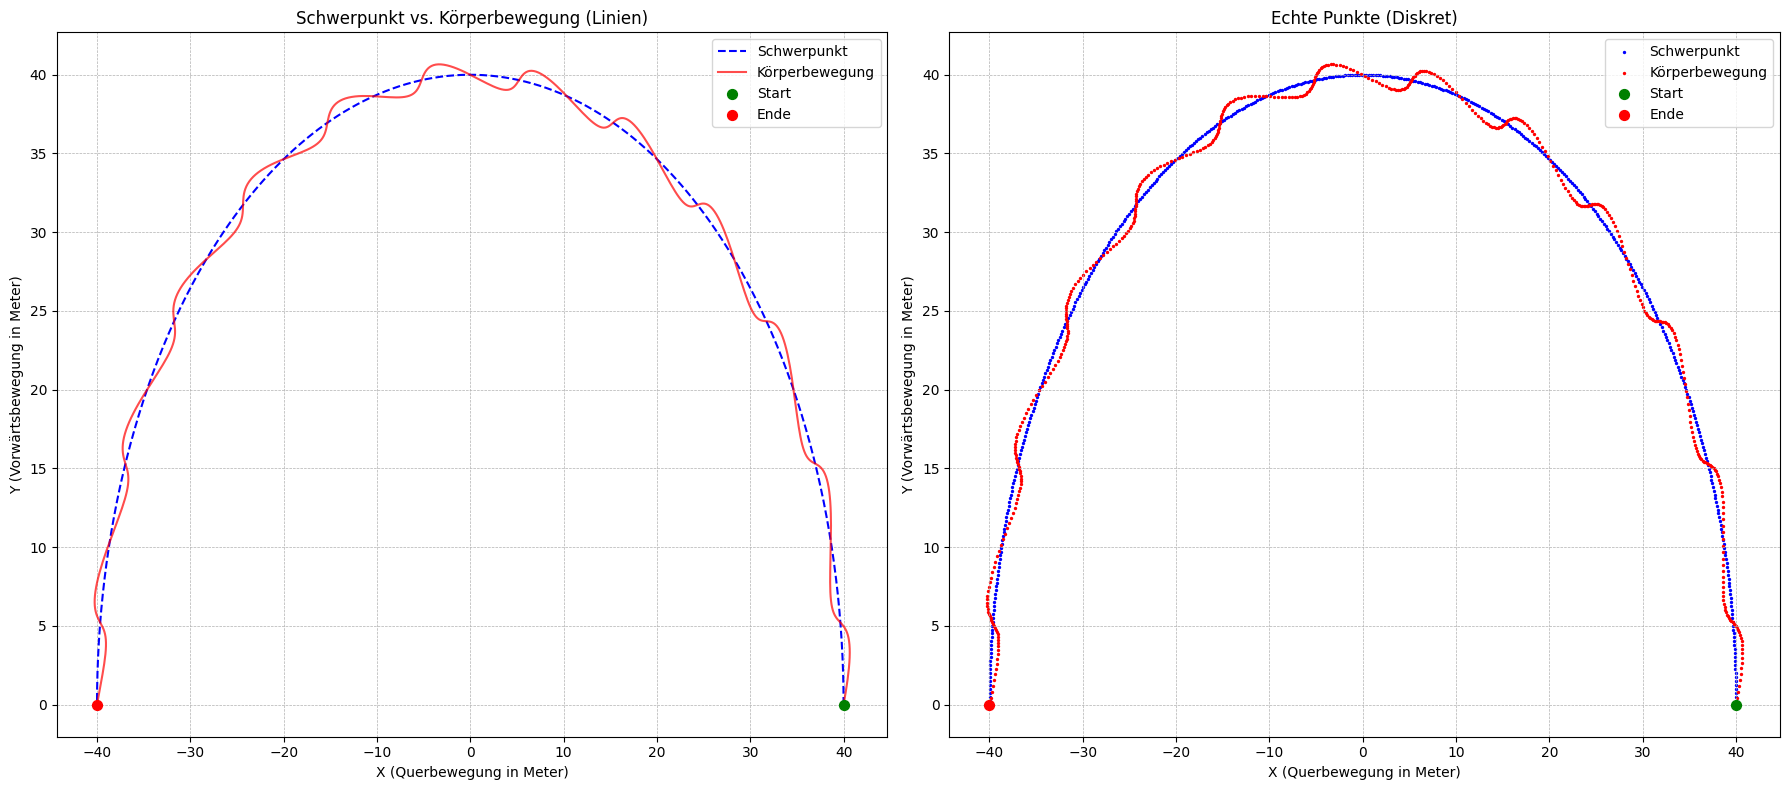

In [414]:
# **Visualisierung der Bewegung mit zwei Plots nebeneinander:**
# 1️⃣ Links: Vollständige Linien für Schwerpunkt & Körperbewegung
# 2️⃣ Rechts: Nur die echten Punkte (diskrete Datenpunkte)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# **Plot 1: Schwerpunkt & Körperbewegung (Linien)**
axes[0].plot(df_testdata_LOF["x_sp"], df_testdata_LOF["y_sp"], color="blue", linestyle="--", label="Schwerpunkt")
axes[0].plot(df_testdata_LOF["x"], df_testdata_LOF["y"], color="red", linestyle="-", alpha=0.7, label="Körperbewegung")

# **Start- und Endpunkt markieren**
axes[0].scatter(df_testdata_LOF["x_sp"].iloc[0], df_testdata_LOF["y_sp"].iloc[0], color="green", label="Start", zorder=3, s=50)
axes[0].scatter(df_testdata_LOF["x_sp"].iloc[-1], df_testdata_LOF["y_sp"].iloc[-1], color="red", label="Ende", zorder=3, s=50)

axes[0].set_xlabel("X (Querbewegung in Meter)")
axes[0].set_ylabel("Y (Vorwärtsbewegung in Meter)")
axes[0].set_title("Schwerpunkt vs. Körperbewegung (Linien)")
axes[0].legend()
axes[0].grid(True, linestyle="--", linewidth=0.5)

# **Plot 2: Echte Punkte ohne Verbindungslinien**
axes[1].scatter(df_testdata_LOF["x_sp"], df_testdata_LOF["y_sp"], color="blue", label="Schwerpunkt", s=2)
axes[1].scatter(df_testdata_LOF["x"], df_testdata_LOF["y"], color="red", label="Körperbewegung", s=2)

# **Start- und Endpunkt markieren**
axes[1].scatter(df_testdata_LOF["x_sp"].iloc[0], df_testdata_LOF["y_sp"].iloc[0], color="green", label="Start", zorder=3, s=50)
axes[1].scatter(df_testdata_LOF["x_sp"].iloc[-1], df_testdata_LOF["y_sp"].iloc[-1], color="red", label="Ende", zorder=3, s=50)

axes[1].set_xlabel("X (Querbewegung in Meter)")
axes[1].set_ylabel("Y (Vorwärtsbewegung in Meter)")
axes[1].set_title("Echte Punkte (Diskret)")
axes[1].legend()
axes[1].grid(True, linestyle="--", linewidth=0.5)

# **Plots anzeigen**
plt.tight_layout()
plt.show()

In [415]:
print(df_testdata_MB)
print(df_testdata_LOF)

            t       x_sp          y_sp          x             y       phi  \
0    0.000000  40.000000  0.000000e+00  40.000000  0.000000e+00  0.000000   
1    0.012592  39.999207  2.518294e-01  40.002969  2.543714e-01  0.006296   
2    0.025183  39.996829  5.036488e-01  40.004319  5.087796e-01  0.012592   
3    0.037775  39.992866  7.554483e-01  40.004051  7.632141e-01  0.018887   
4    0.050366  39.987317  1.007218e+00  40.002162  1.017664e+00  0.025183   
..        ...        ...           ...        ...           ...       ...   
495  6.232819 -39.987317  1.007218e+00 -39.971965  1.016903e+00  3.116410   
496  6.245411 -39.992866  7.554483e-01 -39.981395  7.627861e-01  3.122705   
497  6.258002 -39.996829  5.036488e-01 -39.989212  5.085894e-01  3.129001   
498  6.270594 -39.999207  2.518294e-01 -39.995414  2.543238e-01  3.135297   
499  6.283185 -40.000000  4.898587e-15 -40.000000  4.947573e-15  3.141593   

             x_LR          y_vz  streckenlänge  
0    0.000000e+00  0.00000

# Datensatz kofigurieren und zu csv

In [416]:
# **Funktion zur Umwandlung der Testdaten in das gewünschte GPS-Format mit NaN-Entfernung in speed_measured**

def convert_to_gps_format(df_testdata, start_lat=46.500480, start_lon=8.302427, elevation_base=1350, tf_id=11783):
    """
    Wandelt x/y-Meterwerte aus df_testdata in realistische GPS-Koordinaten (Latitude/Longitude) um.
    Berechnet Geschwindigkeit, Höhe und fügt Zeitstempel hinzu.

    Parameter:
    df_testdata (DataFrame): Enthält die simulierten Testdaten mit x, y, t.
    start_lat (float): Startlatitude für die GPS-Umrechnung.
    start_lon (float): Startlongitude für die GPS-Umrechnung.
    elevation_base (float): Basishöhe in Metern.
    tf_id (int): ID für die GPS-Daten.

    Rückgabe:
    DataFrame: Formatierte GPS-Daten mit Geschwindigkeit, Höhe und Timestamps.
    """

    from geopy.distance import geodesic

    # **1️⃣ Umrechnung der X- und Y-Werte in echte Längen-/Breitengrade**
    latitude_corrected = []
    longitude_corrected = []

    for _, row in df_testdata.iterrows():
        # Berechnung der neuen GPS-Koordinaten relativ zum Startpunkt
        new_lat = geodesic(meters=row["y"]).destination((start_lat, start_lon), 0).latitude
        new_lon = geodesic(meters=row["x"]).destination((start_lat, start_lon), 90).longitude

        latitude_corrected.append(new_lat)
        longitude_corrected.append(new_lon)

    # **2️⃣ Geschwindigkeit berechnen (Ableitung der Strecke nach Zeit)**
    dt = np.diff(df_testdata["t"], prepend=df_testdata["t"].iloc[0])  # Zeitschritt
    dx = np.diff(df_testdata["x"], prepend=df_testdata["x"].iloc[0])
    dy = np.diff(df_testdata["y"], prepend=df_testdata["y"].iloc[0])

    speed_measured = np.sqrt(dx**2 + dy**2) / dt  # Geschwindigkeit = Strecke / Zeit

    # **3️⃣ Erstellen des neuen DataFrames mit echten GPS-Koordinaten**
    df_final = pd.DataFrame({
        "latitude": latitude_corrected,
        "longitude": longitude_corrected,
        "elevation": elevation_base + 0.5 * np.sin(df_testdata["phi"]),  # Leichte Höhenvariation für Realismus
        "speed_measured": speed_measured,  # Berechnete Geschwindigkeit
        "timestamp": [(initial_timestamp + timedelta(seconds=t)).isoformat() + "000" for t in df_testdata["t"]],  # ISO-Timestamp
        "discipline_from_name": "XC",  # Konstante Spalte
        "tf_id": tf_id  # Konstante ID
    })

    # **4️⃣ NaN-Werte in "speed_measured" entfernen (durch Interpolation ersetzen)**
    df_final["speed_measured"] = df_final["speed_measured"].interpolate(method='linear')


    df_final = df_final.dropna(subset=["speed_measured"]).reset_index(drop=True)



    df_final["timestamp"] = df_final["timestamp"].apply(
      lambda x: datetime.strptime(x[:23], "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y%m%dT%H%M%S%f")[:-3]  # Entfernt letzte 3 Stellen für Mikrosekundenpräzision
    )


    return df_final

In [417]:
df_final_corrected_Lof = convert_to_gps_format(df_testdata_LOF)
df_final_corrected_Lof

<ipython-input-416-c4a03b8f00ff>:38: RuntimeWarning:

invalid value encountered in divide



,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id
0,46.500484,8.302950,1350.003148,33.372797,20240127T120000012,XC,11783
1,46.500487,8.302951,1350.006296,33.086054,20240127T120000025,XC,11783
2,46.500491,8.302952,1350.009443,32.485610,20240127T120000037,XC,11783
3,46.500494,8.302954,1350.012590,31.589394,20240127T120000050,XC,11783
4,46.500498,8.302955,1350.015737,30.423880,20240127T120000062,XC,11783
...,...,...,...,...,...,...,...
494,46.500494,8.301912,1350.012590,30.092357,20240127T120006232,XC,11783
495,46.500491,8.301911,1350.009443,31.333540,20240127T120006245,XC,11783
496,46.500487,8.301909,1350.006296,32.303964,20240127T120006258,XC,11783
497,46.500484,8.301907,1350.003148,32.977518,20240127T120006270,XC,11783


In [418]:
df_final_corrected_MB = convert_to_gps_format(df_testdata_MB)
df_final_corrected_MB

<ipython-input-416-c4a03b8f00ff>:38: RuntimeWarning:

invalid value encountered in divide



,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id
0,46.500482,8.302948,1350.003148,20.203123,20240127T120000012,XC,11783
1,46.500485,8.302948,1350.006296,20.204960,20240127T120000025,XC,11783
2,46.500487,8.302948,1350.009443,20.206765,20240127T120000037,XC,11783
3,46.500489,8.302948,1350.012590,20.208536,20240127T120000050,XC,11783
4,46.500491,8.302948,1350.015737,20.210275,20240127T120000062,XC,11783
...,...,...,...,...,...,...,...
494,46.500489,8.301906,1350.012590,20.193455,20240127T120006232,XC,11783
495,46.500487,8.301906,1350.009443,20.195452,20240127T120006245,XC,11783
496,46.500485,8.301906,1350.006296,20.197417,20240127T120006258,XC,11783
497,46.500482,8.301906,1350.003148,20.199351,20240127T120006270,XC,11783


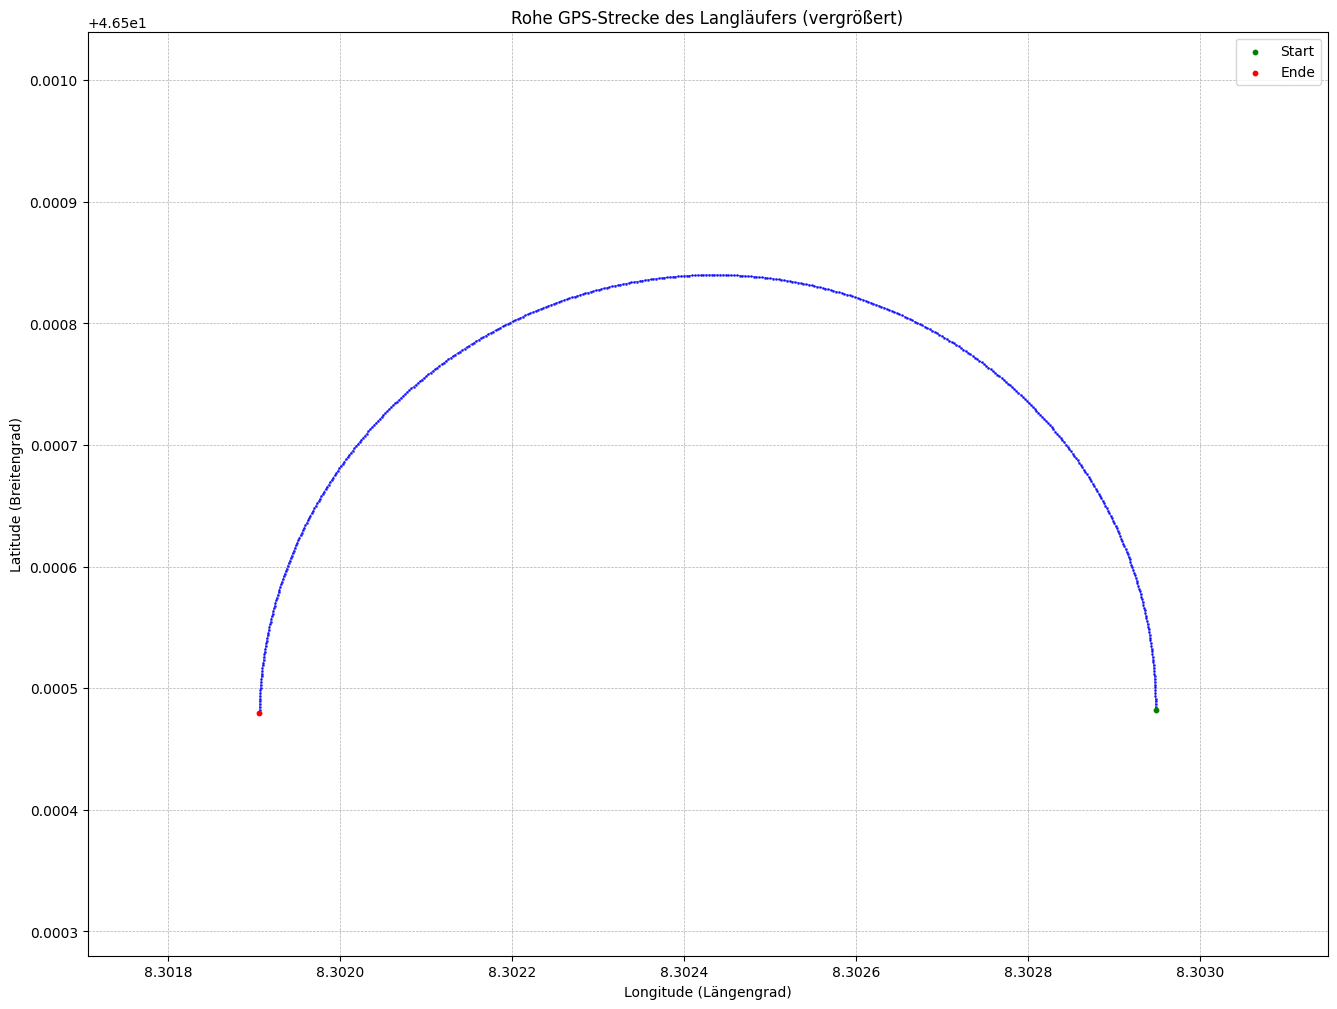

In [419]:
import matplotlib.pyplot as plt

# GPS-Koordinaten aus dem DataFrame extrahieren
latitude = df_final_corrected_MB["latitude"]
longitude = df_final_corrected_MB["longitude"]

# Plot erstellen
plt.figure(figsize=(16, 12))  # Größere Darstellung für bessere Details
plt.plot(longitude, latitude, color="blue", marker="o", linestyle="-", markersize=1, alpha=0.7, linewidth=0.5)

# Start- und Endpunkt markieren
plt.scatter(longitude.iloc[0], latitude.iloc[0], color="green", label="Start", zorder=3, s=10)
plt.scatter(longitude.iloc[-1], latitude.iloc[-1], color="red", label="Ende", zorder=3, s=10)

# Achsenbeschriftung & Titel
plt.xlabel("Longitude (Längengrad)")
plt.ylabel("Latitude (Breitengrad)")
plt.title("Rohe GPS-Strecke des Langläufers (vergrößert)")

# Achsenbereich vergrößern, um Details sichtbar zu machen
plt.xlim(longitude.min() - 0.0002, longitude.max() + 0.0002)
plt.ylim(latitude.min() - 0.0002, latitude.max() + 0.0002)

plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)  # Dünnere Gitterlinien für bessere Übersicht

# Plot anzeigen
plt.show()

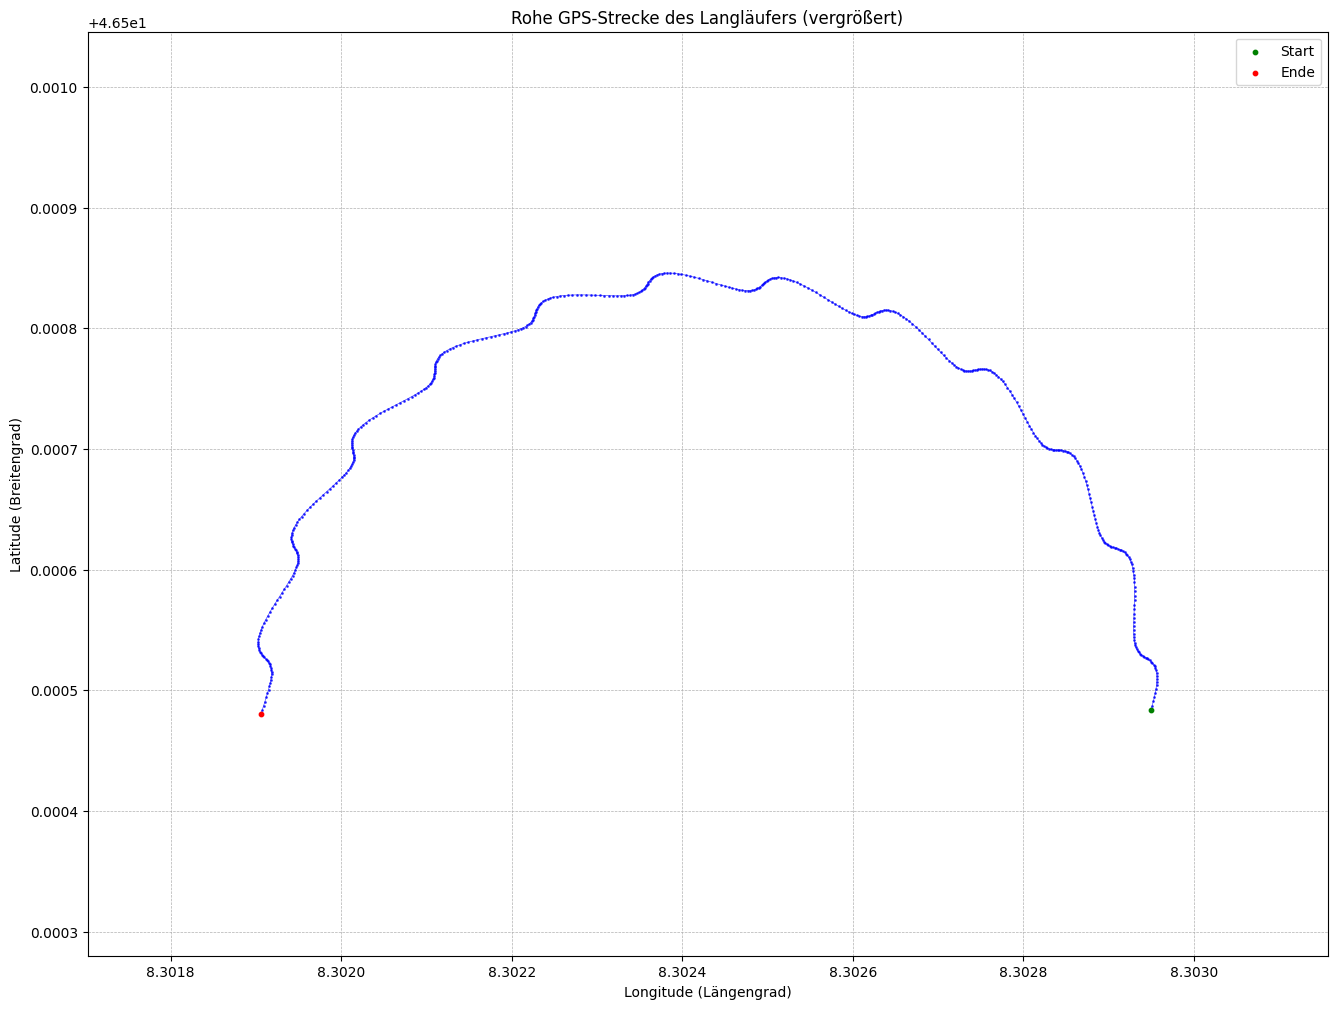

In [420]:
import matplotlib.pyplot as plt

# GPS-Koordinaten aus dem DataFrame extrahieren
latitude = df_final_corrected_Lof["latitude"]
longitude = df_final_corrected_Lof["longitude"]

# Plot erstellen
plt.figure(figsize=(16, 12))  # Größere Darstellung für bessere Details
plt.plot(longitude, latitude, color="blue", marker="o", linestyle="-", markersize=1, alpha=0.7, linewidth=0.5)

# Start- und Endpunkt markieren
plt.scatter(longitude.iloc[0], latitude.iloc[0], color="green", label="Start", zorder=3, s=10)
plt.scatter(longitude.iloc[-1], latitude.iloc[-1], color="red", label="Ende", zorder=3, s=10)

# Achsenbeschriftung & Titel
plt.xlabel("Longitude (Längengrad)")
plt.ylabel("Latitude (Breitengrad)")
plt.title("Rohe GPS-Strecke des Langläufers (vergrößert)")

# Achsenbereich vergrößern, um Details sichtbar zu machen
plt.xlim(longitude.min() - 0.0002, longitude.max() + 0.0002)
plt.ylim(latitude.min() - 0.0002, latitude.max() + 0.0002)

plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)  # Dünnere Gitterlinien für bessere Übersicht

# Plot anzeigen
plt.show()

## Golay testen

In [421]:
import math
from abc import ABC, abstractmethod
from datetime import datetime

import geopy.distance
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from pyproj import Transformer
from scipy.signal import savgol_filter


class PhysicsComputer(ABC):
    """ Contains methods that are common for both SkiAlpine and SkiCrossCountry Class. It's the abstract base class
    that not will be initiated but that will be the blueprint for SkiAlpine and SkiCrossCountry classes."""

    DEFAULT_CONFIG = {
        'savitzky_golay': {
            'window_size':
                {'none': 11, 'DH': 11, 'SX': 11,'GS': 11, 'SL': 7, 'XC': 151},
            'order':
                {'none': 3, 'DH': 3, 'SX': 3, 'GS': 3, 'SL': 3, 'XC': 3}
        }
    }


    def __init__(self, df: pd.DataFrame, config:dict):
        """
        :param df: pandas DataFrame with raw data
        :param config: config dictionary that sets values for different filters aso.
        """
        self._original = df
        self._df = df
        self.config = config

    @abstractmethod
    def compute(self):
        """ Define method that executes all calculations for either SkiAlpine- or SkiCrossCountry-Instance"""
        pass

    def plot(self, feature: str|list[str] = None, title: str = None) -> go.Figure:
        """ Offers a simple plot-API to visualize a singe feature ort multiple features in time

        :param title: optional plot-title as string
        :param feature: feature to be visualized as string or list of features
        """
        features = []
        if feature is None:
            raise f"Please select a feature from DataFrame!"
        elif isinstance(feature, str) and feature not in self._df.columns:
            raise Exception(f"Feature {feature} not found")
        elif isinstance(feature, str) and feature in self._df.columns:
            features.append(feature)
        elif isinstance(feature, list):
            features = [i for i in feature if i in self._df.columns]
            if len(features) == 0:
                raise Exception(f"Feature {feature} not found")
            elif len(features) != len(feature):
                logger.info(f"Dropped {len(feature)- len(features)} feature(s)")

        if len(features) != 0:
            x = self._df['time'] if 'time' in self._df.columns else self._df.index
            title = dict(text=title if title is not None else f"feature: {','.join(features)}", font=dict(size=28))
            if len(features) > 1:
                fig = go.Figure()
                for i in range(len(features)):
                    fig.add_trace(go.Scatter(x=x, y=self._df[features[i]],
                                             mode='lines',
                                             name=features[i]))
            else:
                fig = px.line(self._df, x=x, y=features[0], title=f'{",".join(features)}'.upper())
            fig.update_layout(template='plotly_white', title=title)
            return fig

    def export_csv(self, path: str) -> None:
        """ Exports calculated data to a .csv-File.

        :param path: output-path as string
        """
        EXPORTED_COLUMNS = ['elevation', 'latitude', 'longitude','tf_id', 'discipline_from_name', 'time', 'date',
                            'x_norm', 'y_norm', 'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
                            'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp', 'v_elevation_sp',
                            'a_elevation_sp', 'k', 'k_xy', 'distance', 'distance_x_y', 'v']
        df = self._df[EXPORTED_COLUMNS].copy()
        df.to_csv(path, index=False)

    @staticmethod
    def _transform_to_x_y(coord1: tuple, coord2: tuple) -> (float, float):
        """ Actually transforms the coordinates x and y
        source: https://chatgpt.com/c/71f7ea04-2b95-4b07-96ee-fc5ccbf41532

        :param coord1: tuple containing latitude and longitude of starting point; exp: (46.5, 8.3)
        :param coord2: tuple containing latitude and longitude of ending point; exp: (46.5, 8.3)
        :return: tuple containing 2 floats with distance in meters between the 2 given coordinates in x and y direction
        """
        utm_zone = math.ceil((coord1[1] + 180) / 6)
        hemisphere = 'N' if coord1[0] >= 0 else 'S'
        wgs84 = 'epsg:4326'
        utm = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +{'south' if hemisphere == 'S' else 'north'}"
        transformer = Transformer.from_crs(wgs84, utm)
        x1, y1 = transformer.transform(coord1[0], coord1[1])
        x2, y2 = transformer.transform(coord2[0], coord2[1])
        relative_x = x2 - x1
        relative_y = y2 - y1
        return relative_x, relative_y

    @staticmethod
    def _apply_savitzky_golay(dff: pd.DataFrame, filter_for: tuple, window_size: int, order: int) -> pd.DataFrame:
        """ Applies smoothing with Savitzky-Golay to given columns in pandas DataFrame with certain window_size and order

        :param dff: pandas DataFrame with raw data
        :param filter_for: tuple with column-names in DataFrame as string that should be modified
        :param window_size: length of Savitzky-Golay window as integer
        :param order: order of Savitzky-Golay Filter
        :return: modified pandas DataFrame
        """
        # https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
        # https://gist.github.com/krvajal/1ca6adc7c8ed50f5315fee687d57c3eb
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

        for item in filter_for:
            if item not in dff.columns:
                continue

            val = dff[item].values
            dff[f"{item}_sp"] = savgol_filter(val, window_size, order)
            dff[f"v_{item}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            dff[f"a_{item}_sp"] = savgol_filter(val, window_size, order, deriv=2)

        return dff

    def _modify_config(self, config: dict=None) -> dict:
        """ Modifies config file with the goal that all needed values are existing. If they do not exist in given config
        discipline specific default values from parent class will be taken, else given values will be taken.

        :param config: optional config dictionary that contains values for different filters and settings.
        :return: modified_config (merged with discipline specific DEFAULT_CONFIG from PhysicsComputer) with all needed values
        """
        def _merge_dicts(config, modified_config):
            for key, value in config.items():
                if isinstance(value, dict) and key in modified_config:
                    _merge_dicts(value, modified_config[key])
                else:
                    if key in modified_config:
                        modified_config[key] = value
            return modified_config

        if 'discipline_from_name' not in self._df.columns:
            raise Exception("discipline_from_name not defined in initial DataFrame!")

        discipline = self._df['discipline_from_name'].iloc[0]

        ws = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('window_size').get(discipline)
        order = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('order').get(discipline)
        modified_config = {}
        modified_config.update({'savitzky_golay': {'window_size': ws, 'order': order}})

        if config is not None:
            modified_config = _merge_dicts(config, modified_config)

        if not 'savitzky_golay' in modified_config or not 'window_size' in modified_config[
            'savitzky_golay'] or not 'order' in modified_config['savitzky_golay']:
            raise Exception(f"Something went wrong with initialisation of config! config: {config}")

        return modified_config

    def _convert_timestamp(self) -> None:
        """ Modifies timestamp from format "%Y%m%dT%H%M%S%f" to separate columns date "%Y-%m-%d" and time "%H:%M:%S."
        as string.
        """
        self._df['datetime'] = pd.to_datetime(self._df['timestamp'], format='%Y%m%dT%H%M%S%f')
        self._df["time"] = self._df["datetime"].dt.strftime("%H:%M:%S.") + (
                    self._df['datetime'].dt.microsecond // 100000).astype(str)
        self._df["date"] = self._df["datetime"].dt.strftime("%Y-%m-%d")
        self._df = self._df.drop(columns=["datetime"])

    def _compute_x_y_z(self) -> None:
        """ Transforms the original coordinates in x and y coordinates in meters and x_rel, y_rel and z_rel as difference
        between 2 measuring points. The starting point for x and y will always be at (0,0)
        """

        self._df = self._df.reset_index(drop=True)
        # transform columns to numeric columns -> all non-numeric values will be set to nan
        self._df['latitude'] = pd.to_numeric(self._df['latitude'], errors="coerce")
        self._df['longitude'] = pd.to_numeric(self._df['longitude'], errors="coerce")
        self._df.dropna(subset=['longitude', 'latitude'], inplace=True)
        # calculates distance im meters from actoil location to starting point
        self._df['x_y_from_origin'] = self._df.apply(
            lambda x: self._transform_to_x_y((self._df.loc[0, 'latitude'], self._df.loc[0, 'longitude']),
                                       (x['latitude'], x['longitude'])), axis=1)
        self._df[['x_norm', 'y_norm']] = pd.DataFrame(self._df['x_y_from_origin'].tolist(), index=self._df.index)
        self._df['x_rel'] = self._df['x_norm'].diff()
        self._df['y_rel'] = self._df['y_norm'].diff()
        if 'z' in self._df.columns:
            self._df['z_rel'] = self._df['z'].diff()
        self._df.drop('x_y_from_origin', axis=1, inplace=True)

    def _compute_savitzky_golay_and_derivatives(self) -> None:
        """ Calls savitzky-golay-filter for defined features
        """
        filter_for =  ('x_norm', 'y_norm', 'elevation')
        self._df = self._apply_savitzky_golay(dff=self._df,
                                        filter_for=filter_for,
                                        window_size=self.config['savitzky_golay']['window_size'],
                                        order=self.config['savitzky_golay']['order'])

    def _compute_k(self) -> None:
        """ Computes 'curvature'
        """
        def _calc_k_3D(row: pd.Series) -> float:
            v = [row['v_x_norm_sp'], row['v_y_norm_sp'], row['v_elevation_sp']]
            a = [row['a_x_norm_sp'], row['a_y_norm_sp'], row['a_elevation_sp']]
            cp = np.cross(v, a)
            l = math.sqrt(cp[0] ** 2 + cp[1] ** 2 + cp[2] ** 2)
            v_sp = math.sqrt(row['v_x_norm_sp'] ** 2 + row['v_y_norm_sp'] ** 2 + row['v_elevation_sp'] ** 2)
            return l / v_sp ** 3

        self._df['k'] = self._df.apply(lambda row: pd.Series(_calc_k_3D(row)), axis=1)

    def _compute_k_xy(self) -> None:
        """ Calculates 'curvature' in 2-dimensional-space (x-y-plane)
        """

        def _calc_k_2D(row: pd.Series) -> float:
            vx, vy = row['v_x_norm_sp'], row['v_y_norm_sp']  # 2D-Geschwindigkeitskomponenten
            ax, ay = row['a_x_norm_sp'], row['a_y_norm_sp']  # 2D-Beschleunigungskomponenten
            cp = vx * ay - vy * ax  # 2D-"Kreuzprodukt" (nur Betrag für xy-Ebene)
            v_sp = math.sqrt(vx ** 2 + vy ** 2) # Betrag der Geschwindigkeit in 2D
            return abs(cp) / v_sp ** 3

        self._df['k_xy'] = self._df.apply(lambda row: pd.Series(_calc_k_2D(row)), axis=1)

    def _compute_distances(self) -> None:
        """ Computes distances between 2 coordinate-points
        """
        # add shifts to x_norm, y_norm, latitude and longitude
        self._df['shifted_x_norm'] = self._df['x_norm'].shift(periods=1)
        self._df['shifted_y_norm'] = self._df['y_norm'].shift(periods=1)
        self._df['shifted_latitude'] = self._df['latitude'].shift(periods=1)
        self._df['shifted_longitude'] = self._df['longitude'].shift(periods=1)

        def _calculate_distance(row: pd.Series) -> float:
            """ Calculation of distance in meters between 2 coordinate points based on original longitude and latitude

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance between last 2 coordinate points in meters
            """

            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            return geopy.distance.geodesic((row['latitude'], row['longitude']),
                                           (row['shifted_latitude'], row['shifted_longitude'])).m

        def _calculate_distance_from_x_y(row: pd.Series) -> float:
            """ Calculation of distance in meters based on transformed x and y (metric) coordinates. This calculation is used
            to validate either coordinate transformation and calculation of distance

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance in [m] between 2 coordinates
            """
            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            distance = math.sqrt(
                (row['x_norm'] - row['shifted_x_norm']) ** 2 + (row['y_norm'] - row['shifted_y_norm']) ** 2)
            return distance

        self._df['distance'] = self._df.apply(_calculate_distance, axis=1)
        self._df['distance_x_y'] = self._df.apply(_calculate_distance_from_x_y, axis=1)

    def _compute_v(self) -> None:
        """ Calculates speed
        """
        def _calculate_time_delta(df: pd.DataFrame) -> pd.DataFrame:
            """ Transforms single columns 'date' and 'time' to a date_time column in the datetime-format with tenth of a second
            ('%Y-%m-%d %H:%M:%S.%f') and adds feature 'time_delta' that is 'date_time' shifted by one period.

            :param df: pandas DataFrame with raw data
            :return: modified pandas DataFrame with added/modified date_time content
            """
            df["date_time"] = df["date"] + " " + df["time"]

            try:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
            except ValueError:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

            df['shifted_date_time'] = df['date_time'].shift(periods=1)
            df.loc[0, 'shifted_date_time'] = df.loc[0, 'date_time']
            df['time_delta'] = df['date_time'] - df['shifted_date_time']
            df['time_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
            return df

        def _calculate_speed(row: pd.Series) -> float:
            """ Calculates the speed in [m/s] based on distance between 2 calculated x and y coordinates and the according
            time-gap between this 2 coordinates

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a speed calculation in [m/s] as float
            """
            if row['time_delta'] == 0:
                return 0
            speed = row['distance_x_y'] / row['time_delta']
            return speed

        self._df = _calculate_time_delta(self._df)
        self._df["v"] = self._df.apply(lambda row: pd.Series(_calculate_speed(row)), axis=1)

In [422]:
import pandas as pd
from loguru import logger



class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config:dict=None):
        """
        :param df: pandas DataFrame with raw values
        :param config: optional config dictionary that sets values for different filters aso.
        """
        self._df = df
        config = self._modify_config(config)
        super().__init__(df, config)

    @staticmethod
    def _compute_xc_specific_physical_size() -> None:
        """ Computes cross-country-specific physical sizes (at the moment none).
        """
        logger.info("xc specific")

    def compute(self):
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()
        return self._df

In [427]:
import pandas as pd
from loguru import logger

class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config: dict = None):
        """ Initialisiert SkiCrossCountry mit anpassbaren Filter-Parametern """
        self._df = df

        # Savitzky-Golay-Parameter direkt setzen
        if config is None:
            config = {
                "savitzky_golay": {
                    "window_size":11,  # Stanadart Wert 151
                    "order": 3,  # Polynomgrad Standart 3
                }
            }

        config = self._modify_config(config)
        super().__init__(df, config)

    def _compute_xc_specific_physical_size(self):
        """ Placeholder-Funktion für spezifische XC-Berechnungen """
        logger.info("Cross-Country spezifische Berechnungen werden durchgeführt.")
        # Falls es eine Berechnung gibt, kann sie hier implementiert werden
        return None  # Oder Berechnungen durchführen

    def compute(self):
        """ Führt alle Berechnungen durch """
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()  # Jetzt existiert die Methode!
        return self._df

In [438]:
xc = SkiCrossCountry(df=df_final_corrected_MB)
df_modified = xc.compute()
print(df_modified.columns)
df_modified

2025-03-17 17:31:51.295 | INFO     | __main__:_compute_xc_specific_physical_size:23 - Cross-Country spezifische Berechnungen werden durchgeführt.


Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v'],
      dtype='object')


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_x_norm,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v
0,46.500482,8.302948,1350.003148,20.203123,20240127T120000012,XC,11783,12:00:00.0,2024-01-27,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 12:00:00.000,2024-01-27 12:00:00.000,0.0,0.0
1,46.500485,8.302948,1350.006296,20.204960,20240127T120000025,XC,11783,12:00:00.0,2024-01-27,0.003594,...,0.000000,0.000000,46.500482,8.302948,0.254412,0.254319,2024-01-27 12:00:00.000,2024-01-27 12:00:00.000,0.0,0.0
2,46.500487,8.302948,1350.009443,20.206765,20240127T120000037,XC,11783,12:00:00.0,2024-01-27,0.005570,...,0.003594,0.254294,46.500485,8.302948,0.254435,0.254342,2024-01-27 12:00:00.000,2024-01-27 12:00:00.000,0.0,0.0
3,46.500489,8.302948,1350.012590,20.208536,20240127T120000050,XC,11783,12:00:00.0,2024-01-27,0.005927,...,0.005570,0.508628,46.500487,8.302948,0.254457,0.254364,2024-01-27 12:00:00.000,2024-01-27 12:00:00.000,0.0,0.0
4,46.500491,8.302948,1350.015737,20.210275,20240127T120000062,XC,11783,12:00:00.0,2024-01-27,0.004664,...,0.005927,0.762991,46.500489,8.302948,0.254479,0.254386,2024-01-27 12:00:00.000,2024-01-27 12:00:00.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,46.500489,8.301906,1350.012590,20.193455,20240127T120006232,XC,11783,12:00:06.2,2024-01-27,-79.935902,...,-79.922619,1.722096,46.500491,8.301906,0.254267,0.254174,2024-01-27 12:00:06.200,2024-01-27 12:00:06.200,0.0,0.0
495,46.500487,8.301906,1350.009443,20.195452,20240127T120006245,XC,11783,12:00:06.2,2024-01-27,-79.947574,...,-79.935902,1.468269,46.500489,8.301906,0.254292,0.254199,2024-01-27 12:00:06.200,2024-01-27 12:00:06.200,0.0,0.0
496,46.500485,8.301906,1350.006296,20.197417,20240127T120006258,XC,11783,12:00:06.2,2024-01-27,-79.957633,...,-79.947574,1.214338,46.500487,8.301906,0.254317,0.254224,2024-01-27 12:00:06.200,2024-01-27 12:00:06.200,0.0,0.0
497,46.500482,8.301906,1350.003148,20.199351,20240127T120006270,XC,11783,12:00:06.2,2024-01-27,-79.966079,...,-79.957633,0.960313,46.500485,8.301906,0.254341,0.254248,2024-01-27 12:00:06.200,2024-01-27 12:00:06.200,0.0,0.0


In [439]:
fig = xc.plot(feature=["a_x_norm_sp", "a_y_norm_sp", "a_elevation_sp"], title="Gefilterte Beschleunigung (Savitzky-Golay-Filter)")
fig.show()


TypeError: object of type 'int' has no len()

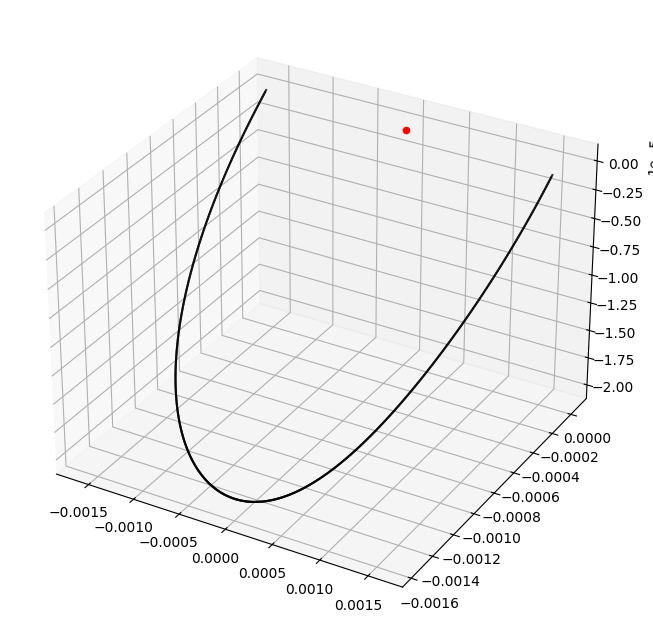

In [440]:

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Nullpunkt setzen (die Werte sind relativ dazu)
x = df_modified["a_x_norm_sp"]
y = df_modified["a_y_norm_sp"]
z = df_modified["a_elevation_sp"]  # Z-Achse für 3D-Darstellung


# Einzigartige Gears extrahieren & Farben zuweisen

# 3D-Figur erstellen
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Farbiges Plotten je nach Gear
for i in range(len(x) - 1):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=technic_mapping.get(technic.iloc[i], "black"), alpha=0.8)

# Nullpunkt markieren
ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")

# Legende für Gears erstellen
for gear, color in technic_mapping.items():
    ax.scatter([], [], [], color=color, label=f"Gear: {gear}")  # Leere Punkte für Legende

# Achsen & Titel
ax.set_xlabel("X-Achse")
ax.set_ylabel("Y-Achse")
ax.set_zlabel("Z-Achse")
ax.set_title("3D-Projektion der Inner-Body-Bewegung mit Gear-Farben")
ax.legend()
plt.show()

ValueError: 0 is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

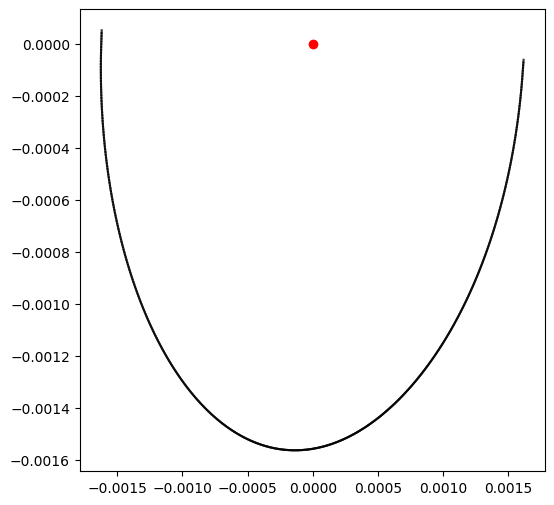

In [441]:

import matplotlib.pyplot as plt
import numpy as np

# Nullpunkt setzen (die Werte sind relativ dazu)
x = df_modified["a_x_norm_sp"]
y = df_modified["a_y_norm_sp"]






plt.figure(figsize=(6, 6))

# Farbiges Plotten je nach Gear
for i in range(len(x) - 1):
    plt.plot(x[i:i+2], y[i:i+2], color=technic_mapping.get(technic.iloc[i], "black"), alpha=0.8)

# Nullpunkt markieren
plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")

# Legende manuell erstellen**: Marker für jede Gear-Farbe hinzufügen
legend_patches = [plt.Line2D([0], [0], color=color, lw=3, label=f"Gear: {gear}")
                  for gear, color in technic_mapping.items()]

plt.legend(handles=legend_patches, loc="upper right")

# Achsen & Titel
plt.xlabel("X-Achse")
plt.ylabel("Y-Achse")
plt.title("2D-Projektion mit Gear-Farben")
plt.grid(True)
plt.show()

# Wie sieht die Inner Body aus (muss a_LR, a_vz anderst berechnet werden)